In [1]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。
# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
sys.path.append("../ecg-classification/")
# sys.path.append("C:\\Users\\Chen_Lab01\\Documents\\GitHub/ecg-classification")
# from IPython.display import Video
# import cv2
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
import matplotlib
matplotlib.use("TkAgg")
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。
# print(sys.path)
from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer



## Data

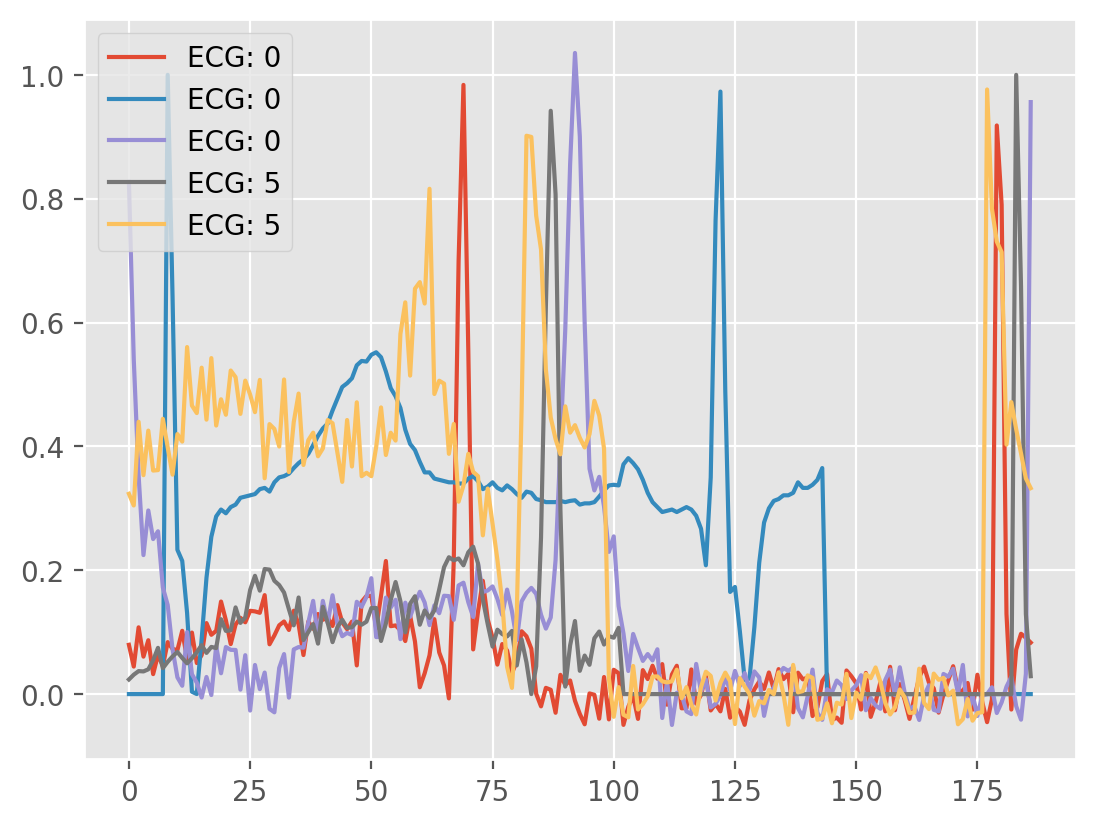

In [2]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

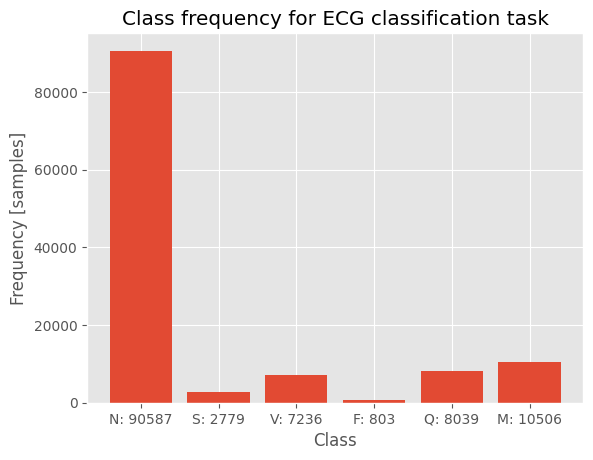

In [3]:
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)
classes = ["N", "S", "V", "F", "Q", "M"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [8]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model
from torchinfo import summary
# input = (batch_size, signal_length, input_channels)
summary(model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層
# print(model)




Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            384                       --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Quantization Test

In [5]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

quantized_model
from torchinfo import summary
summary(quantized_model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=5) # depth = 3 表示只顯示到第三層
# print(model)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            --                        --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Model ParameterTest

In [6]:
for name in quantized_model.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco

### Visualize Model

In [9]:
quantized_model.eval()
inputs = torch.randn(1, 187, 1)
traced_script_module = torch.jit.trace(quantized_model, inputs)
traced_script_module.save("traced_resnet_model.pth")

# from torchviz import make_dot
# vis_graph = make_dot(quantized_model(inputs), params=dict(quantized_model.named_parameters()), show_attrs=True, show_saved=True)
# vis_graph.view()  # 会在当前目录下保存一个“Digraph.gv.pdf”文件，并在默认浏览器中打开

# import netron
# modelData = 'traced_resnet_model.pth'
# netron.start(modelData)

## Training

TRAINING: 0, loss: 0.6276820302009583. Target: [0, 0, 5, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:17<00:00, 19.36it/s] 


TRAINING Accuracy: 0.7924687266349792
[[69785   243   796   100  1359   187]
 [ 1811   265    82     2    56     7]
 [ 3433    73  1591    28   650    13]
 [  577     0     7    56     1     0]
 [ 1893    26   209     1  4271    31]
 [ 7625    56   301    15   299   109]]
epoch_loss: 0.00041845468680063884


VALIDATION: 0, loss: 1.0616892576217651. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 0, 0, 1, 0, 0, 0, 5]: 100%|██████████| 375/375 [00:07<00:00, 49.18it/s] 


VALIDATION Accuracy: 0.8493333458900452
[[17488    15    12     5     8   589]
 [  325   185    20     0     1    25]
 [  577     4   756    19    16    76]
 [  124     0     3    34     0     1]
 [  108     0     4     0  1374   122]
 [ 1516     6    21     5     6   547]]


TRAINING: 1, loss: 0.3547464609146118. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:22<00:00, 18.14it/s] 


TRAINING Accuracy: 0.8412708044052124
[[69151   570   699   335   348  1367]
 [ 1178   864    93     1    29    58]
 [ 1672   109  3566   108   220   113]
 [  372     4    19   239     1     6]
 [  615    27   163     1  5438   187]
 [ 6310   115   281    29   166  1504]]
epoch_loss: 0.0002364976406097412


TRAINING: 2, loss: 1.0452677011489868. Target: [3, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 1500/1500 [01:22<00:00, 18.15it/s] 


TRAINING Accuracy: 0.8574479222297668
[[68764   624   652   334   354  1742]
 [ 1009  1030    92     2    14    76]
 [ 1254    88  4058   119   151   118]
 [  305     6    42   280     0     8]
 [  446    24   119     1  5681   160]
 [ 5466    77   230    20   110  2502]]
epoch_loss: 0.0006968451340993245


VALIDATION: 2, loss: 0.7184935808181763. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 49.08it/s] 


VALIDATION Accuracy: 0.8848333358764648
[[16857    88   127   128     4   913]
 [  185   322    13     0     1    35]
 [  161    12  1185    53     3    34]
 [   38     0     7   116     0     1]
 [   92     0    20     5  1399    92]
 [  722     0    15     6     1  1357]]


TRAINING: 3, loss: 0.4245770573616028. Target: [0, 0, 0, 2, 0, 5, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 5]: 100%|██████████| 1500/1500 [01:23<00:00, 17.90it/s] 


TRAINING Accuracy: 0.8686145544052124
[[68651   618   597   362   272  1970]
 [  915  1160    70     2    12    64]
 [  969    66  4336   138   121   158]
 [  258     1    48   330     0     4]
 [  378    10    95     1  5788   159]
 [ 4911    73   179    18   102  3122]]
epoch_loss: 0.0002830513715744019


TRAINING: 4, loss: 0.5835452079772949. Target: [2, 0, 0, 0, 0, 0, 0, 0], Prediction: [5, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:25<00:00, 17.56it/s] 


TRAINING Accuracy: 0.8765624761581421
[[68681   591   617   346   252  1983]
 [  873  1214    69     1    12    54]
 [  870    63  4477   117   101   160]
 [  239     6    37   348     0    11]
 [  374     7    82     1  5825   142]
 [ 4460    63   169    21    87  3605]]
epoch_loss: 0.00038903013865152993


VALIDATION: 4, loss: 0.6267479062080383. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 4, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.42it/s] 


VALIDATION Accuracy: 0.9127916693687439
[[17327    25   149    28    37   551]
 [  207   309    13     0     3    24]
 [  151     6  1220    33    10    28]
 [   50     0    11    99     0     2]
 [   60     1    14     0  1493    40]
 [  585     1    32     0    24  1459]]


TRAINING: 5, loss: 0.372400164604187. Target: [0, 0, 1, 0, 0, 0, 0, 0], Prediction: [5, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.90it/s]  


TRAINING Accuracy: 0.8811458349227905
[[68552   602   584   358   260  2114]
 [  840  1242    55     1    20    65]
 [  779    68  4563   123   108   147]
 [  232     5    40   355     2     7]
 [  327    10    76     0  5866   152]
 [ 4035    97   158    19    84  4012]]
epoch_loss: 0.00024826677640279137


TRAINING: 6, loss: 0.7754529714584351. Target: [0, 0, 0, 5, 0, 0, 0, 5], Prediction: [0, 0, 0, 5, 0, 5, 0, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.91it/s] 


TRAINING Accuracy: 0.8855624794960022
[[68537   573   578   305   287  2190]
 [  794  1290    53     1    10    75]
 [  718    59  4626   129   110   146]
 [  226     3    42   366     0     4]
 [  328     6    73     1  5899   124]
 [ 3808    61   144    19    77  4296]]
epoch_loss: 0.0005169686476389567


VALIDATION: 6, loss: 0.34923872351646423. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.88it/s]


VALIDATION Accuracy: 0.9102500081062317
[[16860    79   141    98    11   928]
 [  164   349    16     0     0    27]
 [   84     3  1295    26    11    29]
 [   28     0    18   116     0     0]
 [   65     0    12     0  1481    50]
 [  312     8    26     1     9  1745]]


TRAINING: 7, loss: 0.6979216933250427. Target: [0, 0, 2, 0, 5, 2, 0, 1], Prediction: [0, 0, 2, 0, 5, 2, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.90it/s] 


TRAINING Accuracy: 0.8884166479110718
[[68477   644   577   301   245  2226]
 [  779  1316    50     1    12    65]
 [  692    58  4677   120   100   141]
 [  200     3    38   396     1     3]
 [  310     8    64     1  5925   123]
 [ 3630    57   121    19    81  4497]]
epoch_loss: 0.00046528112888336183


TRAINING: 8, loss: 0.17523398995399475. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.76it/s]


TRAINING Accuracy: 0.891166627407074
[[68497   609   589   289   240  2246]
 [  751  1339    54     5    11    63]
 [  694    57  4689   107    80   161]
 [  206     1    41   384     0     9]
 [  304     9    68     0  5936   114]
 [ 3417    76   107    17    81  4707]]
epoch_loss: 0.00011682265996932984


VALIDATION: 8, loss: 0.6213331818580627. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.65it/s]  


VALIDATION Accuracy: 0.9309583306312561
[[17691   111    76    29    56   154]
 [  194   348     8     0     2     4]
 [  120    18  1232    43    10    25]
 [   42     0     7   112     1     0]
 [   46     0     4     0  1546    12]
 [  644    11    10     2    20  1414]]


TRAINING: 9, loss: 0.22211690247058868. Target: [2, 0, 0, 0, 4, 0, 0, 0], Prediction: [2, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.81it/s]


TRAINING Accuracy: 0.895437479019165
[[68516   587   564   318   258  2227]
 [  751  1350    49     1    11    61]
 [  651    64  4725   118    81   149]
 [  213     1    40   376     0    11]
 [  289     5    63     1  5968   105]
 [ 3091    81   128    14    64  5027]]
epoch_loss: 0.00014807793498039246


TRAINING: 10, loss: 0.2148032933473587. Target: [0, 0, 0, 2, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.81it/s] 


TRAINING Accuracy: 0.8992499709129333
[[68679   572   518   287   240  2174]
 [  728  1365    61     0    10    59]
 [  626    58  4760   114    73   157]
 [  185     2    43   404     1     6]
 [  290     2    59     1  5982    97]
 [ 2999    73   113    15    67  5138]]
epoch_loss: 0.0001432021955649058


VALIDATION: 10, loss: 0.39746350049972534. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.48it/s] 


VALIDATION Accuracy: 0.9356250166893005
[[17524    77   109    26    95   286]
 [  190   345    11     0     5     5]
 [   90    12  1241    32    27    46]
 [   44     0    10   107     1     0]
 [   30     1     0     0  1559    18]
 [  378     5    10     0    29  1679]]


TRAINING: 11, loss: 0.14554470777511597. Target: [0, 0, 5, 0, 0, 0, 0, 5], Prediction: [0, 0, 5, 0, 0, 0, 0, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.82it/s]


TRAINING Accuracy: 0.9012708067893982
[[68661   587   557   309   215  2141]
 [  697  1389    60     0     6    71]
 [  603    46  4780   110    97   152]
 [  181     2    38   409     0    11]
 [  280     8    69     0  5973   101]
 [ 2801    74   117    20    83  5310]]
epoch_loss: 9.702980518341065e-05


TRAINING: 12, loss: 0.3162198066711426. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:21<00:00, 18.32it/s] 


TRAINING Accuracy: 0.9036562442779541
[[68733   586   488   306   236  2121]
 [  672  1413    53     2    12    71]
 [  583    58  4832   100    75   140]
 [  175     1    45   412     1     7]
 [  270     8    62     1  5996    94]
 [ 2800    62   103    15    60  5365]]
epoch_loss: 0.00021081320444742838


VALIDATION: 12, loss: 0.3832493722438812. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 49.43it/s]  


VALIDATION Accuracy: 0.9371666312217712
[[17567    40    50    24   102   334]
 [  206   326     9     0     4    11]
 [  135     4  1240    40     7    22]
 [   48     0     4   110     0     0]
 [   33     0    10     0  1543    22]
 [  363     3     9     1    19  1706]]


TRAINING: 13, loss: 0.19573314487934113. Target: [0, 0, 0, 2, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.53it/s]


TRAINING Accuracy: 0.9052500128746033
[[68689   586   530   274   239  2152]
 [  685  1422    44     2     5    65]
 [  583    58  4830   104    77   136]
 [  168     3    44   418     1     7]
 [  276     7    54     2  6003    89]
 [ 2592    65   111    13    82  5542]]
epoch_loss: 0.00013048876325289408


TRAINING: 14, loss: 0.07914084196090698. Target: [4, 0, 0, 0, 0, 0, 4, 0], Prediction: [4, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.75it/s]


TRAINING Accuracy: 0.9089583158493042
[[68877   541   533   270   236  2013]
 [  683  1424    44     1     6    65]
 [  576    43  4869    98    81   121]
 [  167     5    39   422     0     8]
 [  267     4    58     1  6023    78]
 [ 2504    77    95    16    68  5645]]
epoch_loss: 5.276056130727132e-05


VALIDATION: 14, loss: 0.22216005623340607. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.57it/s]


VALIDATION Accuracy: 0.9157083034515381
[[16798   257   101    20    51   890]
 [  132   385    12     0     2    25]
 [   93    16  1272    31     4    32]
 [   35     0    10   116     0     1]
 [   38     2    10     0  1537    21]
 [  192     8    19     1    12  1869]]


TRAINING: 15, loss: 0.06761714816093445. Target: [4, 0, 4, 2, 0, 5, 0, 0], Prediction: [4, 0, 4, 2, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.74it/s]


TRAINING Accuracy: 0.9089791774749756
[[68809   592   514   257   219  2079]
 [  658  1445    51     1     9    59]
 [  579    56  4855    98    71   129]
 [  168     1    41   424     0     7]
 [  263     4    64     1  6021    78]
 [ 2454    61   107     9    66  5708]]
epoch_loss: 4.50780987739563e-05


TRAINING: 16, loss: 0.1985160857439041. Target: [0, 0, 0, 0, 0, 0, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.82it/s] 


TRAINING Accuracy: 0.9110729098320007
[[68871   570   484   263   244  2038]
 [  659  1453    43     1    10    57]
 [  570    44  4898    98    54   124]
 [  171     3    39   421     0     7]
 [  267     4    63     0  6016    81]
 [ 2365    56    96    14    70  5804]]
epoch_loss: 0.00013234405716260275


VALIDATION: 16, loss: 0.4131529927253723. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.00it/s]  


VALIDATION Accuracy: 0.9421666860580444
[[17557   148   133    84    27   168]
 [  158   379    14     1     1     3]
 [   78     9  1290    46     7    18]
 [   26     0     8   127     0     1]
 [   48     0    12     0  1535    13]
 [  321    15    23     4    14  1724]]


TRAINING: 17, loss: 0.4205835163593292. Target: [5, 0, 5, 0, 0, 1, 4, 0], Prediction: [5, 0, 0, 0, 0, 1, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.87it/s] 


TRAINING Accuracy: 0.9103021025657654
[[68719   612   504   298   235  2102]
 [  659  1438    55     1    13    57]
 [  561    40  4912    94    57   124]
 [  155     1    40   435     0    10]
 [  265     5    46     0  6032    83]
 [ 2327    60    95    16    54  5853]]
epoch_loss: 0.0002803890109062195


TRAINING: 18, loss: 0.7056891322135925. Target: [0, 0, 0, 5, 5, 5, 4, 0], Prediction: [0, 0, 0, 5, 5, 0, 4, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.86it/s]  


TRAINING Accuracy: 0.9148125052452087
[[68930   557   472   276   228  2007]
 [  648  1461    45     1     9    59]
 [  518    45  4962    90    64   109]
 [  162     2    41   429     0     7]
 [  223     5    60     0  6068    75]
 [ 2213    67    86    11    56  5972]]
epoch_loss: 0.00047045942147572834


VALIDATION: 18, loss: 0.3097763657569885. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.67it/s]  


VALIDATION Accuracy: 0.9475833177566528
[[17847    34    44    18    12   162]
 [  211   335     6     0     0     4]
 [  136    10  1237    37     8    20]
 [   41     0     6   115     0     0]
 [   55     0     2     0  1537    14]
 [  403     8     7     1    11  1671]]


TRAINING: 19, loss: 0.17200428247451782. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.82it/s]


TRAINING Accuracy: 0.9144583344459534
[[68940   549   465   280   200  2036]
 [  636  1477    38     0     8    64]
 [  517    34  4956   103    71   107]
 [  160     2    44   429     0     6]
 [  257     2    61     2  6025    84]
 [ 2208    59    96     9    72  5961]]
epoch_loss: 0.00011466952164967855


TRAINING: 20, loss: 0.2872155010700226. Target: [5, 5, 0, 0, 0, 5, 0, 0], Prediction: [5, 5, 0, 0, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.77it/s] 


TRAINING Accuracy: 0.9156770706176758
[[68976   562   472   289   208  1963]
 [  618  1500    42     0     7    56]
 [  534    40  4928   103    66   117]
 [  157     1    42   432     0     9]
 [  220     3    61     0  6071    76]
 [ 2179    57    99     8    64  5998]]
epoch_loss: 0.0001914770007133484


VALIDATION: 20, loss: 0.09481924772262573. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.07it/s] 


VALIDATION Accuracy: 0.9394583106040955
[[17271    92   145    51    72   486]
 [  149   372    17     0     2    16]
 [   61     5  1309    35    12    26]
 [   26     0     9   124     1     2]
 [   20     1     9     0  1557    21]
 [  154     5    14     2    12  1914]]


TRAINING: 21, loss: 0.7090757489204407. Target: [0, 0, 0, 0, 5, 0, 0, 2], Prediction: [0, 0, 0, 0, 5, 0, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.82it/s] 


TRAINING Accuracy: 0.9182916283607483
[[69103   527   492   273   220  1855]
 [  633  1475    46     1     8    60]
 [  519    43  4955    89    62   120]
 [  152     1    45   435     0     8]
 [  236     3    52     0  6065    75]
 [ 2070    63    94    10    45  6123]]
epoch_loss: 0.00047271716594696043


TRAINING: 22, loss: 0.5890286564826965. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.69it/s] 


TRAINING Accuracy: 0.9181979298591614
[[68970   588   485   268   214  1945]
 [  627  1496    49     0     8    43]
 [  504    41  4990    87    61   105]
 [  164     3    40   427     0     7]
 [  219     4    56     0  6063    89]
 [ 1992    59    84    15    54  6201]]
epoch_loss: 0.00039268577098846435


VALIDATION: 22, loss: 0.0895143374800682. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.57it/s]  


VALIDATION Accuracy: 0.9322499632835388
[[17034   116   101    26    51   789]
 [  139   375     9     0     0    33]
 [   64    11  1296    25    13    39]
 [   29     0    12   120     0     1]
 [   26     1     6     0  1553    22]
 [   88     2     4     0    11  1996]]


TRAINING: 23, loss: 0.20347996056079865. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.71it/s]


TRAINING Accuracy: 0.9186770915985107
[[69019   581   466   260   192  1952]
 [  591  1539    43     1     9    40]
 [  503    38  4985    84    62   116]
 [  158     2    42   435     1     3]
 [  215     4    60     1  6076    75]
 [ 2065    45    89    13    54  6139]]
epoch_loss: 0.00013565330704053244


TRAINING: 24, loss: 0.8187459111213684. Target: [0, 4, 0, 0, 5, 0, 0, 0], Prediction: [0, 4, 0, 0, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.70it/s] 


TRAINING Accuracy: 0.9206146001815796
[[69104   571   431   265   215  1884]
 [  610  1519    38     2    10    44]
 [  510    35  4985    92    63   103]
 [  137     1    40   456     0     7]
 [  221     4    55     1  6081    69]
 [ 1969    52    81    10    59  6234]]
epoch_loss: 0.0005458306074142456


VALIDATION: 24, loss: 0.08274375647306442. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.49it/s] 


VALIDATION Accuracy: 0.9484999775886536
[[17522    40    68    27     7   453]
 [  175   352    11     0     0    18]
 [   91     3  1282    27     6    39]
 [   26     0     8   124     1     3]
 [   50     1     7     0  1524    26]
 [  128     2     2     1     8  1960]]


TRAINING: 25, loss: 0.17766167223453522. Target: [0, 5, 0, 0, 0, 5, 5, 0], Prediction: [0, 5, 0, 5, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.78it/s]


TRAINING Accuracy: 0.9201353788375854
[[69093   566   488   280   205  1838]
 [  588  1517    44     1     9    64]
 [  516    38  4990    91    49   104]
 [  148     1    40   442     1     9]
 [  218     5    52     1  6073    82]
 [ 1974    53    89     5    66  6218]]
epoch_loss: 0.00011844111482302347


TRAINING: 26, loss: 0.08064614236354828. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.77it/s]


TRAINING Accuracy: 0.9234895706176758
[[69219   563   445   245   203  1795]
 [  597  1536    33     2     7    48]
 [  474    51  5013    82    67   101]
 [  131     4    39   456     0    11]
 [  215     7    57     0  6071    81]
 [ 1824    52    98    14    57  6360]]
epoch_loss: 5.376409490903219e-05


VALIDATION: 26, loss: 0.2724194824695587. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.55it/s]  


VALIDATION Accuracy: 0.9554583430290222
[[17827    59    44    22    30   135]
 [  168   366    14     0     1     7]
 [   82     8  1296    33     7    22]
 [   33     0     7   120     1     1]
 [   36     0     7     0  1552    13]
 [  290     2    16     1    22  1770]]


TRAINING: 27, loss: 0.49688541889190674. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.71it/s]


TRAINING Accuracy: 0.9236249923706055
[[69166   579   441   269   207  1808]
 [  596  1532    40     1     7    47]
 [  469    34  5022    79    67   117]
 [  140     2    42   448     1     8]
 [  223     5    53     0  6093    57]
 [ 1818    58    66     8    48  6407]]
epoch_loss: 0.0003312569459279378


TRAINING: 28, loss: 0.6117905974388123. Target: [4, 0, 0, 1, 1, 0, 0, 0], Prediction: [4, 0, 0, 0, 1, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.77it/s] 


TRAINING Accuracy: 0.9241041541099548
[[69199   577   445   264   193  1792]
 [  578  1545    46     3     6    45]
 [  449    49  5023    94    61   112]
 [  141     1    46   443     1     9]
 [  205     4    53     1  6100    68]
 [ 1823    45    75     8    50  6404]]
epoch_loss: 0.0004078603982925415


VALIDATION: 28, loss: 0.21159039437770844. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.51it/s] 


VALIDATION Accuracy: 0.9523333311080933
[[17642    84    82    62    23   224]
 [  158   379    10     1     0     8]
 [   70     9  1315    27     4    23]
 [   27     0    11   123     0     1]
 [   27     1     9     0  1552    19]
 [  221     5    12     2    16  1845]]


TRAINING: 29, loss: 0.13015615940093994. Target: [0, 0, 1, 0, 2, 0, 0, 0], Prediction: [0, 0, 1, 0, 2, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.78it/s]


TRAINING Accuracy: 0.9244583249092102
[[69244   555   435   255   175  1806]
 [  562  1553    36     1     7    64]
 [  469    46  5012    80    76   105]
 [  136     0    42   455     0     8]
 [  190     6    59     2  6104    70]
 [ 1850    62    49    12    52  6380]]
epoch_loss: 8.677077293395996e-05


TRAINING: 30, loss: 0.2714199721813202. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.74it/s] 


TRAINING Accuracy: 0.9248749613761902
[[69314   547   405   224   216  1764]
 [  584  1537    41     1    11    49]
 [  476    40  5028    96    42   106]
 [  150     2    45   439     0     5]
 [  222     6    57     0  6080    66]
 [ 1810    56    74    17    58  6390]]
epoch_loss: 0.00018094664812088012


VALIDATION: 30, loss: 0.2947084903717041. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.40it/s]  


VALIDATION Accuracy: 0.9517499804496765
[[17698   125    56    12     8   218]
 [  150   392     5     0     0     9]
 [  100     5  1298    26     2    17]
 [   46     0    15   100     0     1]
 [   55     3     6     0  1516    28]
 [  246     6     8     0     3  1838]]


TRAINING: 31, loss: 0.44276535511016846. Target: [0, 5, 0, 0, 0, 0, 1, 0], Prediction: [0, 5, 4, 0, 0, 0, 1, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.79it/s]


TRAINING Accuracy: 0.9247499704360962
[[69173   586   421   266   197  1827]
 [  552  1572    45     1    10    43]
 [  483    42  5030    83    51    99]
 [  149     0    37   449     1     5]
 [  218     5    54     0  6083    71]
 [ 1765    43    73     8    47  6469]]
epoch_loss: 0.000295176903406779


TRAINING: 32, loss: 0.13565024733543396. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.75it/s]


TRAINING Accuracy: 0.9262291789054871
[[69268   606   438   225   194  1739]
 [  552  1565    46     0     6    54]
 [  468    46  5016    86    67   105]
 [  141     3    45   447     1     4]
 [  217     3    55     3  6081    72]
 [ 1684    47    70    14    49  6541]]
epoch_loss: 9.043349822362264e-05


VALIDATION: 32, loss: 0.07001062482595444. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.47it/s]  


VALIDATION Accuracy: 0.9459166526794434
[[17367   110   110   108    21   401]
 [  156   371    15     2     1    11]
 [   44     3  1336    33     4    28]
 [   22     0     8   130     1     1]
 [   26     0    11     0  1557    14]
 [  134     3    13     1     9  1941]]


TRAINING: 33, loss: 0.09091156721115112. Target: [0, 0, 0, 0, 0, 0, 1, 0], Prediction: [0, 0, 0, 0, 0, 0, 1, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.71it/s]


TRAINING Accuracy: 0.9278541803359985
[[69333   567   415   253   200  1702]
 [  564  1562    37     0     4    56]
 [  457    33  5066    84    56    92]
 [  136     0    38   462     1     4]
 [  197     3    45     0  6111    75]
 [ 1680    48    71    12    54  6540]]
epoch_loss: 6.060771147410075e-05


TRAINING: 34, loss: 0.22586391866207123. Target: [0, 0, 5, 0, 0, 0, 5, 4], Prediction: [0, 0, 0, 0, 0, 0, 5, 4]: 100%|██████████| 1500/1500 [01:20<00:00, 18.71it/s]


TRAINING Accuracy: 0.9269583225250244
[[69291   540   459   254   180  1746]
 [  578  1549    36     0     7    53]
 [  457    40  5062    82    55    92]
 [  144     2    40   447     1     7]
 [  214     7    55     0  6076    79]
 [ 1627    56    78     9    72  6563]]
epoch_loss: 0.00015057594577471415


VALIDATION: 34, loss: 0.16485100984573364. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.17it/s] 


VALIDATION Accuracy: 0.9547500014305115
[[17750    47    38    26    17   239]
 [  184   353     3     1     0    15]
 [  119     8  1247    29     3    42]
 [   30     0     9   121     0     2]
 [   33     0     6     0  1540    29]
 [  187     3     1     1     6  1903]]


TRAINING: 35, loss: 0.16136030852794647. Target: [2, 0, 0, 0, 0, 0, 0, 0], Prediction: [2, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:24<00:00, 17.81it/s]


TRAINING Accuracy: 0.9273958206176758
[[69273   591   450   241   193  1722]
 [  565  1563    44     1     4    46]
 [  428    42  5074    85    56   103]
 [  139     1    43   450     1     7]
 [  201     3    49     0  6119    59]
 [ 1686    47    60     8    53  6551]]
epoch_loss: 0.00010757353901863098


TRAINING: 36, loss: 0.1604776829481125. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.63it/s] 


TRAINING Accuracy: 0.9288541674613953
[[69422   539   442   249   193  1625]
 [  554  1584    31     2     4    48]
 [  437    41  5069    77    64   100]
 [  139     0    46   446     1     9]
 [  198     5    46     1  6103    78]
 [ 1670    45    71    11    62  6546]]
epoch_loss: 0.00010698512196540832


VALIDATION: 36, loss: 0.2705048620700836. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.38it/s]  


VALIDATION Accuracy: 0.9505000114440918
[[17573   186   103    27    24   204]
 [  134   403     9     0     0    10]
 [   62    11  1324    34     2    15]
 [   30     0    11   120     0     1]
 [   31     2    14     0  1543    18]
 [  223     3    20     0     6  1849]]


TRAINING: 37, loss: 0.38196054100990295. Target: [5, 0, 0, 0, 4, 0, 0, 0], Prediction: [5, 0, 5, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.78it/s]


TRAINING Accuracy: 0.9285520911216736
[[69331   592   432   233   209  1673]
 [  559  1572    36     2     7    47]
 [  453    38  5080    73    48    96]
 [  128     2    38   469     0     4]
 [  212     3    47     3  6093    73]
 [ 1645    41    71    14    38  6596]]
epoch_loss: 0.00025464036067326864


TRAINING: 38, loss: 0.08059898763895035. Target: [0, 0, 0, 5, 0, 0, 0, 2], Prediction: [0, 0, 0, 5, 0, 0, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.76it/s]


TRAINING Accuracy: 0.9296249747276306
[[69385   566   425   231   184  1679]
 [  563  1568    32     0     5    55]
 [  444    30  5093    80    47    94]
 [  137     1    47   452     1     3]
 [  199     5    42     0  6114    71]
 [ 1596    56    67     9    45  6632]]
epoch_loss: 5.37326584259669e-05


VALIDATION: 38, loss: 0.12642419338226318. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.56it/s] 


VALIDATION Accuracy: 0.9519166350364685
[[17581   107   104    36    14   275]
 [  141   394    12     1     0     8]
 [   56    10  1323    33     4    22]
 [   27     1    13   119     1     1]
 [   27     1    10     1  1545    24]
 [  185    12    15     1     4  1884]]


TRAINING: 39, loss: 0.43162843585014343. Target: [0, 5, 1, 4, 2, 0, 0, 0], Prediction: [0, 5, 1, 4, 2, 2, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.74it/s]


TRAINING Accuracy: 0.9286458492279053
[[69338   542   422   264   200  1704]
 [  567  1556    42     0     8    50]
 [  437    33  5091    74    49   104]
 [  136     2    40   451     1    11]
 [  188     6    57     1  6096    83]
 [ 1586    55    87    11    48  6618]]
epoch_loss: 0.0002877522905667623


TRAINING: 40, loss: 0.49021822214126587. Target: [1, 0, 5, 0, 4, 0, 0, 5], Prediction: [1, 0, 5, 0, 4, 0, 0, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.77it/s]


TRAINING Accuracy: 0.9301562309265137
[[69373   572   437   239   180  1669]
 [  552  1574    36     1     8    52]
 [  445    36  5086    89    44    88]
 [  125     4    46   462     1     3]
 [  207     6    48     0  6098    72]
 [ 1525    46    73     5    54  6702]]
epoch_loss: 0.0003268121480941772


VALIDATION: 40, loss: 0.2224242091178894. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.57it/s]   


VALIDATION Accuracy: 0.9521666765213013
[[17530   237    61    13    91   185]
 [  121   420     8     0     1     6]
 [   70    11  1311    31    11    14]
 [   29     1    10   118     1     3]
 [   13     2     2     0  1579    12]
 [  175     5    11     1    15  1894]]


TRAINING: 41, loss: 0.1420176476240158. Target: [5, 0, 0, 0, 0, 5, 0, 2], Prediction: [5, 0, 0, 0, 0, 5, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.77it/s] 


TRAINING Accuracy: 0.93010413646698
[[69403   561   414   245   188  1659]
 [  545  1581    42     2    12    41]
 [  438    30  5103    78    49    90]
 [  137     0    45   456     0     3]
 [  203     4    53     0  6108    63]
 [ 1590    50    65    11    50  6639]]
epoch_loss: 9.467843174934387e-05


TRAINING: 42, loss: 0.20030121505260468. Target: [0, 1, 0, 0, 0, 0, 1, 0], Prediction: [0, 1, 0, 4, 5, 0, 1, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.85it/s]


TRAINING Accuracy: 0.9298333525657654
[[69363   576   447   256   193  1635]
 [  537  1589    38     0    11    48]
 [  433    46  5072    80    44   113]
 [  142     2    48   443     0     6]
 [  204     3    42     0  6108    74]
 [ 1535    44    74    14    49  6689]]
epoch_loss: 0.00013353414336840313


VALIDATION: 42, loss: 0.18976393342018127. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.65it/s] 


VALIDATION Accuracy: 0.9512082934379578
[[17494   121    98    22    19   363]
 [  126   398     8     1     4    19]
 [   70    11  1301    39     3    24]
 [   30     0     6   125     0     1]
 [   25     0     5     0  1556    22]
 [  122     5    13     0     6  1955]]


TRAINING: 43, loss: 0.27534782886505127. Target: [0, 0, 0, 2, 4, 0, 0, 0], Prediction: [0, 0, 0, 2, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.85it/s] 


TRAINING Accuracy: 0.9318645596504211
[[69493   568   415   203   173  1618]
 [  553  1585    33     0     8    44]
 [  399    48  5115    79    50    97]
 [  130     4    42   461     1     3]
 [  191     7    45     0  6115    73]
 [ 1521    59    70     9    56  6690]]
epoch_loss: 0.0001835652192433675


TRAINING: 44, loss: 0.45989498496055603. Target: [5, 0, 0, 0, 0, 0, 0, 0], Prediction: [5, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:21<00:00, 18.50it/s]


TRAINING Accuracy: 0.930635392665863
[[69335   587   435   233   197  1683]
 [  542  1591    40     0    10    40]
 [  435    33  5125    78    40    77]
 [  126     1    39   464     0    11]
 [  189     3    54     0  6118    67]
 [ 1553    37    53     6    48  6708]]
epoch_loss: 0.0003065966566403707


VALIDATION: 44, loss: 0.39471253752708435. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 49.61it/s] 


VALIDATION Accuracy: 0.9570000171661377
[[17749   134    45    33    24   132]
 [  139   404     6     1     1     5]
 [   85    10  1292    44     2    15]
 [   23     0     7   131     0     1]
 [   29     0     6     0  1556    17]
 [  226     4    13     3    19  1836]]


TRAINING: 45, loss: 0.1807471215724945. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 5]: 100%|██████████| 1500/1500 [01:20<00:00, 18.65it/s] 


TRAINING Accuracy: 0.9329687356948853
[[69563   586   387   201   176  1557]
 [  553  1576    36     2     8    48]
 [  414    39  5107    86    42   100]
 [  125     2    49   460     1     4]
 [  204     3    49     1  6114    60]
 [ 1496    49    60    10    45  6745]]
epoch_loss: 0.00012049808104832967


TRAINING: 46, loss: 0.4461270570755005. Target: [0, 2, 0, 0, 4, 0, 0, 0], Prediction: [5, 2, 0, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.84it/s] 


TRAINING Accuracy: 0.9319062232971191
[[69488   550   434   226   207  1565]
 [  543  1589    36     1     5    49]
 [  451    35  5079    77    51    95]
 [  122     3    44   468     0     4]
 [  199     6    49     1  6120    56]
 [ 1516    41    78     8    43  6719]]
epoch_loss: 0.00029741803805033364


VALIDATION: 46, loss: 0.22922684252262115. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.61it/s]  


VALIDATION Accuracy: 0.9559166431427002
[[17693   143    92    22    13   154]
 [  132   406     9     0     1     8]
 [   69     7  1315    34     5    18]
 [   27     0     8   125     0     2]
 [   35     2     9     0  1541    21]
 [  204    14    13     2     6  1862]]


TRAINING: 47, loss: 0.30442726612091064. Target: [5, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.83it/s]


TRAINING Accuracy: 0.9321041703224182
[[69426   562   477   247   186  1572]
 [  548  1593    36     1     5    40]
 [  422    34  5116    79    45    92]
 [  132     2    39   458     2     8]
 [  192     4    45     1  6124    65]
 [ 1465    56    60     5    54  6765]]
epoch_loss: 0.00020295151074727375


TRAINING: 48, loss: 0.4652157723903656. Target: [0, 0, 0, 2, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:23<00:00, 18.07it/s]  


TRAINING Accuracy: 0.9333958029747009
[[69500   571   411   215   174  1599]
 [  533  1599    33     1    10    47]
 [  417    28  5131    79    45    88]
 [  133     2    41   458     0     7]
 [  185     3    37     0  6145    61]
 [ 1480    43    64     7    38  6773]]
epoch_loss: 0.00031014384826024376


VALIDATION: 48, loss: 0.18198038637638092. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 47.33it/s] 


VALIDATION Accuracy: 0.9547500014305115
[[17634    69    70    40     6   298]
 [  156   377    13     0     0    10]
 [   63     3  1317    39     1    25]
 [   23     0     9   128     0     2]
 [   42     0    13     0  1521    32]
 [  151     2     6     2     3  1937]]


TRAINING: 49, loss: 0.1431499719619751. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:21<00:00, 18.48it/s] 


TRAINING Accuracy: 0.9334999918937683
[[69515   534   403   235   178  1605]
 [  544  1590    39     1     4    45]
 [  402    40  5138    71    57    80]
 [  137     0    39   459     0     6]
 [  173    10    46     0  6145    57]
 [ 1466    58    55     9    48  6769]]
epoch_loss: 9.543331464131674e-05


TRAINING: 50, loss: 0.08343561738729477. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.87it/s]


TRAINING Accuracy: 0.9345312118530273
[[69542   549   427   245   176  1531]
 [  518  1621    30     3     8    43]
 [  412    39  5128    76    45    88]
 [  125     2    42   465     1     6]
 [  179     7    48     0  6140    57]
 [ 1430    42    65    10    39  6819]]
epoch_loss: 5.562374492486318e-05


VALIDATION: 50, loss: 0.2277819961309433. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.85it/s]   


VALIDATION Accuracy: 0.9574166536331177
[[17684   215    38    12    25   143]
 [  129   413     8     0     1     5]
 [   76     6  1302    32     9    23]
 [   30     1     8   121     1     1]
 [   22     2     5     0  1562    17]
 [  173    25     1     0     6  1896]]


TRAINING: 51, loss: 0.6621218323707581. Target: [0, 0, 0, 5, 2, 0, 2, 0], Prediction: [0, 0, 0, 5, 0, 0, 2, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.88it/s]  


TRAINING Accuracy: 0.9353333115577698
[[69568   617   376   197   154  1558]
 [  510  1614    40     1     8    50]
 [  404    32  5144    76    49    83]
 [  122     2    45   466     0     6]
 [  158     6    45     1  6155    66]
 [ 1392    51    69     7    41  6845]]
epoch_loss: 0.00044141455491383873


TRAINING: 52, loss: 0.057416051626205444. Target: [4, 0, 0, 2, 0, 0, 0, 0], Prediction: [4, 0, 0, 2, 0, 0, 0, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.90it/s]


TRAINING Accuracy: 0.9327499866485596
[[69502   541   422   213   163  1629]
 [  513  1612    38     0     9    51]
 [  436    35  5096    91    47    83]
 [  135     2    39   460     0     5]
 [  202     8    50     2  6113    56]
 [ 1468    51    66    13    46  6761]]
epoch_loss: 3.827736775080363e-05


VALIDATION: 52, loss: 0.22777089476585388. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.57it/s]  


VALIDATION Accuracy: 0.953249990940094
[[17548   298    53    12    16   190]
 [  115   427     6     0     1     7]
 [   81    11  1317    10     6    23]
 [   38     0    16   106     0     2]
 [   22     2     5     0  1560    19]
 [  157    11     6     0     7  1920]]


TRAINING: 53, loss: 0.16427913308143616. Target: [2, 0, 0, 4, 0, 4, 0, 0], Prediction: [2, 0, 0, 4, 0, 4, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.90it/s]


TRAINING Accuracy: 0.9336562156677246
[[69527   569   392   221   167  1594]
 [  543  1595    35     1     8    41]
 [  405    37  5119    77    55    95]
 [  123     3    40   468     0     7]
 [  182     5    48     1  6136    59]
 [ 1451    50    65     9    44  6786]]
epoch_loss: 0.00010951942205429077


TRAINING: 54, loss: 0.22877895832061768. Target: [0, 0, 0, 5, 0, 0, 0, 2], Prediction: [0, 0, 0, 5, 0, 0, 0, 2]: 100%|██████████| 1500/1500 [01:20<00:00, 18.72it/s]


TRAINING Accuracy: 0.93401038646698
[[69514   594   428   228   174  1532]
 [  541  1591    32     0     9    50]
 [  431    38  5115    70    48    86]
 [  119     2    40   476     0     4]
 [  175     3    48     0  6149    56]
 [ 1420    50    62     7    46  6820]]
epoch_loss: 0.00015251930554707844


VALIDATION: 54, loss: 0.1742052435874939. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.57it/s]  


VALIDATION Accuracy: 0.9587916731834412
[[17741   105    58    26    16   171]
 [  142   401     9     1     1     2]
 [   73     4  1298    38     3    32]
 [   29     0     7   126     0     0]
 [   27     2     8     0  1549    22]
 [  185    13     2     2     3  1896]]


TRAINING: 55, loss: 0.12821847200393677. Target: [0, 0, 5, 0, 4, 0, 0, 0], Prediction: [0, 0, 5, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.92it/s] 


TRAINING Accuracy: 0.9360833168029785
[[69608   559   406   206   167  1524]
 [  506  1617    41     1     9    49]
 [  392    31  5144    76    51    94]
 [  117     0    43   473     0     8]
 [  179     4    46     1  6142    59]
 [ 1357    57    69     5    37  6880]]
epoch_loss: 8.547898133595785e-05


TRAINING: 56, loss: 0.13698820769786835. Target: [0, 5, 0, 2, 2, 0, 0, 5], Prediction: [0, 5, 0, 2, 2, 0, 0, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.82it/s]


TRAINING Accuracy: 0.9350312352180481
[[69489   592   387   217   195  1590]
 [  535  1599    41     1     7    40]
 [  384    45  5163    71    42    83]
 [  121     2    35   478     0     5]
 [  178     4    49     3  6136    61]
 [ 1360    38    59     7    43  6898]]
epoch_loss: 9.13254717985789e-05


VALIDATION: 56, loss: 0.18202091753482819. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.52it/s]  


VALIDATION Accuracy: 0.9598749876022339
[[17822    91    43    14    36   111]
 [  145   396     8     0     4     3]
 [   77     7  1309    22    21    12]
 [   30     0    13   117     0     2]
 [   23     1     5     0  1566    13]
 [  247     7     8     0    12  1827]]


TRAINING: 57, loss: 0.12825694680213928. Target: [0, 0, 5, 5, 0, 0, 0, 2], Prediction: [0, 0, 5, 5, 0, 0, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.84it/s] 


TRAINING Accuracy: 0.9363853931427002
[[69622   596   398   210   159  1485]
 [  514  1616    33     2     9    49]
 [  399    41  5142    89    40    77]
 [  122     0    41   469     2     7]
 [  168     4    46     1  6165    47]
 [ 1375    55    54     9    33  6879]]
epoch_loss: 8.550463120142618e-05


TRAINING: 58, loss: 0.11873649805784225. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [4, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:22<00:00, 18.09it/s] 


TRAINING Accuracy: 0.9371979236602783
[[69695   522   393   245   161  1454]
 [  529  1611    32     0     7    44]
 [  414    38  5130    73    44    89]
 [  120     1    42   470     1     7]
 [  169     4    38     1  6162    57]
 [ 1337    45    69    10    41  6903]]
epoch_loss: 7.915766537189483e-05


VALIDATION: 58, loss: 0.15093068778514862. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 47.52it/s] 


VALIDATION Accuracy: 0.9565833210945129
[[17678   112    68    37    23   199]
 [  144   390    11     0     1    10]
 [   67    10  1295    43     5    28]
 [   23     0     6   132     0     1]
 [   24     0     6     1  1561    16]
 [  182     5     6     0     6  1902]]


TRAINING: 59, loss: 0.19184879958629608. Target: [0, 0, 0, 0, 0, 0, 2, 2], Prediction: [0, 0, 0, 0, 0, 0, 2, 2]: 100%|██████████| 1500/1500 [01:22<00:00, 18.14it/s] 


TRAINING Accuracy: 0.9364895820617676
[[69605   533   435   222   180  1495]
 [  520  1610    28     4     8    53]
 [  395    30  5147    77    48    91]
 [  121     1    42   471     1     5]
 [  193    11    35     0  6145    47]
 [ 1327    48    58    10    37  6925]]
epoch_loss: 0.0001278991997241974


TRAINING: 60, loss: 0.3450602889060974. Target: [0, 5, 0, 5, 0, 0, 0, 0], Prediction: [0, 5, 0, 5, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:23<00:00, 17.98it/s] 


TRAINING Accuracy: 0.9369375109672546
[[69629   556   417   221   167  1480]
 [  520  1607    35     1     8    52]
 [  402    37  5157    70    43    79]
 [  114     2    46   473     0     6]
 [  184     4    40     0  6147    56]
 [ 1301    53    66     9    43  6933]]
epoch_loss: 0.00023004019260406495


VALIDATION: 60, loss: 0.17448975145816803. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 49.36it/s]  


VALIDATION Accuracy: 0.9578750133514404
[[17658   167    81    45    32   134]
 [  121   421     6     1     3     4]
 [   66    10  1310    40     9    13]
 [   20     0     7   133     1     1]
 [   19     1     2     0  1576    10]
 [  170    10    14     1    15  1891]]


TRAINING: 61, loss: 0.06523296236991882. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.95it/s] 


TRAINING Accuracy: 0.9373437166213989
[[69639   563   414   228   164  1462]
 [  509  1629    35     1    10    39]
 [  393    41  5160    78    39    77]
 [  114     1    42   479     1     4]
 [  143     4    38     4  6188    54]
 [ 1362    46    59    10    38  6890]]
epoch_loss: 4.348864157994588e-05


TRAINING: 62, loss: 0.07851014286279678. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.60it/s]


TRAINING Accuracy: 0.937375009059906
[[69617   538   385   234   194  1502]
 [  505  1626    29     0    10    53]
 [  368    37  5189    72    37    85]
 [  125     4    44   462     1     5]
 [  166     4    39     0  6166    56]
 [ 1329    50    56    10    32  6928]]
epoch_loss: 5.234009524186452e-05


VALIDATION: 62, loss: 0.24803727865219116. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 49.70it/s]  


VALIDATION Accuracy: 0.9577082991600037
[[17788   141    37    31    23    97]
 [  125   416     8     1     1     5]
 [   84     8  1279    42    15    20]
 [   22     0     9   130     0     1]
 [   22     1     6     0  1566    13]
 [  268    16     3     0     8  1806]]


TRAINING: 63, loss: 0.06815002858638763. Target: [0, 0, 4, 0, 0, 4, 0, 0], Prediction: [0, 0, 4, 0, 0, 4, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.88it/s] 


TRAINING Accuracy: 0.9403854012489319
[[69782   541   373   211   155  1408]
 [  473  1654    38     3     6    49]
 [  403    26  5169    76    37    77]
 [  118     0    44   474     1     4]
 [  174     1    43     1  6165    47]
 [ 1220    36    63     6    47  7033]]
epoch_loss: 4.543335239092509e-05


TRAINING: 64, loss: 0.14877116680145264. Target: [0, 0, 5, 0, 0, 4, 0, 0], Prediction: [0, 0, 5, 0, 0, 4, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.83it/s] 


TRAINING Accuracy: 0.937624990940094
[[69605   554   423   241   178  1469]
 [  498  1651    28     1     5    40]
 [  387    40  5160    76    55    70]
 [  110     3    45   471     3     9]
 [  171     4    45     1  6159    51]
 [ 1292    45    61     6    35  6966]]
epoch_loss: 9.918077786763509e-05


VALIDATION: 64, loss: 0.06843318790197372. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.32it/s]  


VALIDATION Accuracy: 0.9575833082199097
[[17599   171    69    28    26   224]
 [  118   422     8     0     1     7]
 [   66     8  1323    33     1    17]
 [   23     1     8   128     0     2]
 [   18     2    13     0  1559    16]
 [  134     8     4     2     2  1951]]


TRAINING: 65, loss: 0.052265483886003494. Target: [0, 5, 0, 2, 0, 0, 0, 0], Prediction: [0, 5, 0, 2, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.91it/s]


TRAINING Accuracy: 0.9385625123977661
[[69667   554   386   220   177  1466]
 [  510  1623    37     1     6    46]
 [  384    27  5191    73    47    66]
 [  105     3    41   484     2     6]
 [  165     6    48     3  6158    51]
 [ 1269    45    59     5    48  6979]]
epoch_loss: 3.4843655924002326e-05


TRAINING: 66, loss: 0.1490568369626999. Target: [5, 0, 0, 0, 0, 0, 0, 0], Prediction: [5, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.84it/s] 


TRAINING Accuracy: 0.937541663646698
[[69571   579   415   215   190  1500]
 [  524  1635    22     0     2    40]
 [  398    27  5165    71    57    70]
 [  106     3    42   484     1     5]
 [  167     5    45     1  6157    56]
 [ 1267    40    52     8    46  6992]]
epoch_loss: 9.937122464179992e-05


VALIDATION: 66, loss: 0.12183086574077606. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.60it/s] 


VALIDATION Accuracy: 0.9557916522026062
[[17618   178    35    32    13   241]
 [  125   419     6     1     0     5]
 [   94    19  1287    26     5    17]
 [   30     0    13   114     1     4]
 [   30     2     5     0  1557    14]
 [  128    13     5     2     9  1944]]


TRAINING: 67, loss: 0.1080741137266159. Target: [0, 0, 1, 0, 5, 0, 0, 5], Prediction: [0, 0, 1, 0, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.86it/s]  


TRAINING Accuracy: 0.937958300113678
[[69650   536   413   223   182  1466]
 [  509  1630    33     2     7    42]
 [  389    38  5179    61    36    85]
 [  105     3    35   490     1     7]
 [  175     8    41     0  6155    52]
 [ 1306    46    59     9    45  6940]]
epoch_loss: 7.204940915107728e-05


TRAINING: 68, loss: 0.10903377085924149. Target: [0, 4, 0, 5, 0, 0, 0, 0], Prediction: [0, 4, 0, 5, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.92it/s] 


TRAINING Accuracy: 0.9394166469573975
[[69670   568   392   240   181  1419]
 [  512  1627    34     1     5    44]
 [  372    42  5196    68    40    70]
 [  114     2    43   477     0     5]
 [  170     5    24     2  6176    54]
 [ 1222    51    57     4    33  7038]]
epoch_loss: 7.268918057282765e-05


VALIDATION: 68, loss: 0.13869701325893402. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.76it/s]  


VALIDATION Accuracy: 0.9561249613761902
[[17585   125   107   125    10   165]
 [  125   406    13     2     2     8]
 [   55     9  1331    30     5    18]
 [   15     0    10   136     0     1]
 [   21     1     9     1  1561    15]
 [  156     2     8     2     5  1928]]


TRAINING: 69, loss: 0.34619399905204773. Target: [0, 0, 0, 0, 4, 0, 0, 1], Prediction: [0, 0, 0, 0, 4, 0, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.91it/s]


TRAINING Accuracy: 0.9384791851043701
[[69648   561   406   217   165  1473]
 [  513  1625    35     1     5    44]
 [  388    41  5177    67    43    72]
 [  108     0    45   483     0     5]
 [  166     5    38     1  6169    52]
 [ 1255    49    70     7    32  6992]]
epoch_loss: 0.00023079599936803183


TRAINING: 70, loss: 0.07866238057613373. Target: [5, 0, 0, 5, 0, 0, 1, 0], Prediction: [5, 0, 0, 5, 0, 0, 1, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.87it/s] 


TRAINING Accuracy: 0.9381353855133057
[[69689   561   404   216   172  1428]
 [  508  1643    32     0     3    37]
 [  391    30  5151    77    46    93]
 [  110     2    46   473     2     8]
 [  162     6    49     2  6143    69]
 [ 1269    45    71    11    47  6962]]
epoch_loss: 5.244158705075582e-05


VALIDATION: 70, loss: 0.16220331192016602. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 0, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.67it/s] 


VALIDATION Accuracy: 0.9601666331291199
[[17694   131   117    13    16   146]
 [  117   417    16     2     1     3]
 [   43     7  1365    17     6    10]
 [   30     0    17   113     0     2]
 [   16     2    14     0  1563    13]
 [  184     2    16     1     6  1892]]


TRAINING: 71, loss: 0.05449826270341873. Target: [2, 0, 0, 0, 0, 0, 0, 0], Prediction: [2, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.85it/s] 


TRAINING Accuracy: 0.9394791722297668
[[69648   547   390   237   183  1465]
 [  474  1672    26     0     8    43]
 [  360    37  5196    70    40    85]
 [  102     1    44   487     1     6]
 [  175     5    43     1  6165    42]
 [ 1237    49    52     8    37  7022]]
epoch_loss: 3.6332175135612485e-05


TRAINING: 72, loss: 0.0704592913389206. Target: [0, 5, 0, 0, 0, 0, 4, 0], Prediction: [0, 5, 0, 0, 0, 0, 4, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.89it/s] 


TRAINING Accuracy: 0.9412291646003723
[[69786   519   368   207   182  1408]
 [  479  1658    35     1    10    40]
 [  361    39  5209    61    49    69]
 [  109     2    48   475     0     7]
 [  175     3    43     0  6163    47]
 [ 1206    40    53     3    36  7067]]
epoch_loss: 4.697286089261373e-05


VALIDATION: 72, loss: 0.11633322387933731. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.59it/s]  


VALIDATION Accuracy: 0.9573333263397217
[[17570   125   105    42    17   258]
 [  118   417    17     0     1     3]
 [   60     7  1325    30     2    24]
 [   23     0     9   128     0     2]
 [   19     1    14     0  1556    18]
 [  109     6     3     0     3  1980]]


TRAINING: 73, loss: 0.24681299924850464. Target: [3, 0, 5, 0, 0, 0, 5, 5], Prediction: [3, 0, 0, 0, 0, 0, 5, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.84it/s] 


TRAINING Accuracy: 0.9420104026794434
[[69829   514   382   220   170  1355]
 [  486  1659    29     1     5    43]
 [  356    40  5198    76    40    78]
 [  115     1    43   477     1     4]
 [  168     4    34     0  6169    56]
 [ 1172    34    57     7    34  7101]]
epoch_loss: 0.0001645419994990031


TRAINING: 74, loss: 0.11887354403734207. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.86it/s] 


TRAINING Accuracy: 0.9410416483879089
[[69742   546   374   198   163  1447]
 [  487  1666    28     1     9    32]
 [  369    38  5184    79    43    75]
 [  107     3    45   477     1     8]
 [  168     3    41     0  6169    50]
 [ 1165    37    49    10    42  7102]]
epoch_loss: 7.924902935822805e-05


VALIDATION: 74, loss: 0.3066413104534149. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.75it/s]  


VALIDATION Accuracy: 0.9589999914169312
[[17769   166    77    22     2    81]
 [  121   419    13     0     1     2]
 [   68    16  1330    28     1     5]
 [   29     0    10   123     0     0]
 [   49     0    12     0  1531    16]
 [  231     8    14     1     3  1844]]


TRAINING: 75, loss: 0.24085572361946106. Target: [0, 0, 4, 0, 0, 0, 2, 4], Prediction: [0, 0, 4, 0, 0, 0, 0, 4]: 100%|██████████| 1500/1500 [01:19<00:00, 18.85it/s] 


TRAINING Accuracy: 0.9425728917121887
[[69824   567   361   207   150  1361]
 [  485  1660    31     3     6    38]
 [  371    28  5205    58    49    77]
 [  100     1    48   487     1     4]
 [  154     5    39     1  6182    50]
 [ 1140    38    52    12    34  7129]]
epoch_loss: 0.00016057048241297403


TRAINING: 76, loss: 0.13539420068264008. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.91it/s]


TRAINING Accuracy: 0.9402708411216736
[[69726   532   408   210   161  1433]
 [  489  1642    42     0     7    43]
 [  374    35  5191    72    48    68]
 [  119     3    41   473     1     4]
 [  164     7    42     0  6172    46]
 [ 1184    55    63     4    37  7062]]
epoch_loss: 9.026280045509339e-05


VALIDATION: 76, loss: 0.1406826376914978. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.67it/s]   


VALIDATION Accuracy: 0.9612083435058594
[[17757    75    87    12    11   175]
 [  138   395    14     2     0     7]
 [   70     6  1323    30     4    15]
 [   30     0    13   118     0     1]
 [   31     1    10     0  1553    13]
 [  165     5     4     1     3  1923]]


TRAINING: 77, loss: 0.30853182077407837. Target: [0, 0, 0, 0, 4, 0, 5, 0], Prediction: [0, 0, 0, 0, 4, 0, 5, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.58it/s] 


TRAINING Accuracy: 0.9407187104225159
[[69747   589   387   222   141  1384]
 [  488  1660    34     2     4    35]
 [  372    20  5199    78    47    72]
 [  121     1    41   470     1     7]
 [  162     8    39     0  6177    45]
 [ 1208    44    55     5    37  7056]]
epoch_loss: 0.00020568788051605224


TRAINING: 78, loss: 0.3739355504512787. Target: [0, 5, 5, 0, 0, 0, 0, 4], Prediction: [0, 0, 5, 0, 0, 0, 0, 4]: 100%|██████████| 1500/1500 [01:20<00:00, 18.64it/s]  


TRAINING Accuracy: 0.942145824432373
[[69817   535   369   209   168  1372]
 [  485  1656    36     1     6    39]
 [  338    32  5230    69    36    83]
 [  122     0    38   477     1     3]
 [  163     5    45     0  6167    51]
 [ 1164    47    49     8    38  7099]]
epoch_loss: 0.00024929036696751914


VALIDATION: 78, loss: 0.1840297430753708. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.80it/s]  


VALIDATION Accuracy: 0.9635416269302368
[[17797    94    60    22    17   127]
 [  124   411    13     0     1     7]
 [   62     7  1341    17     5    16]
 [   25     0    17   119     0     1]
 [   34     0    13     0  1549    12]
 [  174     4     7     1     7  1908]]


TRAINING: 79, loss: 0.32539957761764526. Target: [0, 5, 0, 3, 0, 0, 0, 0], Prediction: [0, 0, 0, 3, 0, 1, 0, 5]: 100%|██████████| 1500/1500 [01:19<00:00, 18.92it/s] 


TRAINING Accuracy: 0.9412291646003723
[[69764   525   410   216   153  1402]
 [  475  1674    28     1     4    41]
 [  349    32  5214    73    48    72]
 [  110     1    39   485     1     5]
 [  163     4    43     1  6172    48]
 [ 1218    48    50     5    35  7049]]
epoch_loss: 0.00021693305174509683


TRAINING: 80, loss: 0.11267895996570587. Target: [0, 0, 2, 4, 0, 0, 0, 2], Prediction: [0, 0, 2, 4, 5, 0, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.91it/s] 


TRAINING Accuracy: 0.9418125152587891
[[69804   582   368   228   160  1328]
 [  488  1649    32     0     8    46]
 [  326    34  5247    74    40    67]
 [  106     1    48   480     1     5]
 [  173     6    45     0  6160    47]
 [ 1187    46    55     7    36  7074]]
epoch_loss: 7.511930664380392e-05


VALIDATION: 80, loss: 0.1545543670654297. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.59it/s]   


VALIDATION Accuracy: 0.9620416760444641
[[17664   123    66    10    41   213]
 [  123   416     9     0     2     6]
 [   49     9  1344    12    13    21]
 [   26     0    24   108     1     3]
 [   13     3     3     0  1576    13]
 [  104     6     3     0     7  1981]]


TRAINING: 81, loss: 0.20074620842933655. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.89it/s] 


TRAINING Accuracy: 0.9421353936195374
[[69791   535   372   257   172  1343]
 [  470  1659    34     1     8    51]
 [  351    30  5230    80    38    59]
 [  117     3    44   475     0     2]
 [  149     6    44     0  6181    51]
 [ 1164    41    54     6    31  7109]]
epoch_loss: 0.0001338308056195577


TRAINING: 82, loss: 0.1961449831724167. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 1, 0, 0, 4, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.86it/s]  


TRAINING Accuracy: 0.9419375061988831
[[69820   586   373   201   153  1337]
 [  473  1653    32     0     5    60]
 [  358    30  5223    74    39    64]
 [  108     1    44   478     1     9]
 [  165     6    32     1  6178    49]
 [ 1198    35    54     7    37  7074]]
epoch_loss: 0.00013076332211494447


VALIDATION: 82, loss: 0.18523114919662476. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.33it/s]  


VALIDATION Accuracy: 0.9597916603088379
[[17581   167    60    67    35   207]
 [  106   427     9     1     2    11]
 [   41     6  1339    34     9    19]
 [   17     0     9   134     0     2]
 [   16     2     2     0  1579     9]
 [  113     3     3     1     6  1975]]


TRAINING: 83, loss: 0.31666693091392517. Target: [0, 0, 2, 0, 2, 0, 0, 0], Prediction: [0, 2, 2, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.91it/s] 


TRAINING Accuracy: 0.9440416693687439
[[69888   568   384   204   137  1289]
 [  478  1673    22     3     8    39]
 [  338    39  5242    66    30    73]
 [  114     2    39   482     0     4]
 [  139     6    41     1  6197    47]
 [ 1121    42    51     9    36  7146]]
epoch_loss: 0.00021111128727595012


TRAINING: 84, loss: 0.08001825958490372. Target: [0, 0, 0, 0, 5, 4, 0, 0], Prediction: [0, 0, 0, 0, 5, 4, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.86it/s] 


TRAINING Accuracy: 0.9434478878974915
[[69844   518   402   203   148  1355]
 [  486  1669    32     1     4    31]
 [  357    26  5226    75    34    70]
 [  110     0    36   489     1     5]
 [  136     9    32     0  6215    39]
 [ 1126    55    55     6    35  7128]]
epoch_loss: 5.3345506389935814e-05


VALIDATION: 84, loss: 0.21044541895389557. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.63it/s]  


VALIDATION Accuracy: 0.9580416679382324
[[17594   231    55    38    23   176]
 [  103   437    11     0     1     4]
 [   43    15  1342    24     5    19]
 [   18     0    17   122     0     5]
 [   14     3     2     0  1573    16]
 [  149    14     7     1     5  1925]]


TRAINING: 85, loss: 0.07116721570491791. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.80it/s] 


TRAINING Accuracy: 0.942479133605957
[[69772   544   375   214   171  1394]
 [  442  1682    40     2     7    50]
 [  347    34  5215    81    36    75]
 [   96     1    50   489     0     5]
 [  161     3    36     1  6181    49]
 [ 1116    47    60     9    34  7139]]
epoch_loss: 4.7444810469945274e-05


TRAINING: 86, loss: 0.2660295069217682. Target: [5, 0, 0, 0, 4, 4, 2, 2], Prediction: [5, 0, 0, 0, 4, 4, 0, 2]: 100%|██████████| 1500/1500 [01:21<00:00, 18.38it/s]  


TRAINING Accuracy: 0.9427604079246521
[[69818   563   408   177   149  1355]
 [  486  1656    27     2     7    45]
 [  347    30  5220    76    45    70]
 [  103     0    42   492     0     4]
 [  154     8    42     0  6184    43]
 [ 1129    36    61     7    37  7135]]
epoch_loss: 0.00017735300461451214


VALIDATION: 86, loss: 0.11633681505918503. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 47.27it/s] 


VALIDATION Accuracy: 0.9618749618530273
[[17710   119    51    45     9   183]
 [  128   410     6     1     1    10]
 [   66     7  1326    33     2    14]
 [   20     0     8   133     0     1]
 [   27     3     7     2  1549    20]
 [  129     5     7     1     2  1957]]


TRAINING: 87, loss: 0.5468446016311646. Target: [0, 5, 5, 0, 0, 2, 0, 0], Prediction: [0, 5, 5, 5, 0, 2, 0, 0]: 100%|██████████| 1500/1500 [01:24<00:00, 17.77it/s]  


TRAINING Accuracy: 0.9419896006584167
[[69766   531   398   224   162  1389]
 [  499  1644    23     3    12    42]
 [  342    28  5223    70    48    77]
 [  102     0    48   485     0     6]
 [  154     8    48     1  6170    50]
 [ 1117    43    59     7    36  7143]]
epoch_loss: 0.0003645630677541097


TRAINING: 88, loss: 0.029675805941224098. Target: [0, 0, 2, 4, 0, 0, 0, 0], Prediction: [0, 0, 2, 4, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.87it/s]


TRAINING Accuracy: 0.9431979060173035
[[69773   552   398   225   161  1361]
 [  471  1680    29     0     6    37]
 [  341    30  5250    62    37    68]
 [   93     4    39   496     1     8]
 [  150     8    42     0  6180    51]
 [ 1084    50    54     4    45  7168]]
epoch_loss: 1.9783870627482732e-05


VALIDATION: 88, loss: 0.1730431616306305. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.67it/s]   


VALIDATION Accuracy: 0.9599999785423279
[[17631   173    68    35    12   198]
 [  110   422    10     2     1    11]
 [   58     4  1341    29     4    12]
 [   20     0     8   133     0     1]
 [   21     5    10     0  1559    13]
 [  132     3     8     1     3  1954]]


TRAINING: 89, loss: 0.20080341398715973. Target: [0, 0, 4, 5, 5, 0, 0, 0], Prediction: [0, 2, 4, 5, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.89it/s] 


TRAINING Accuracy: 0.9443437457084656
[[69886   545   378   213   146  1302]
 [  468  1682    26     2     7    38]
 [  346    32  5238    68    36    68]
 [  107     1    50   480     1     2]
 [  143     4    35     2  6197    50]
 [ 1098    44    54     1    34  7174]]
epoch_loss: 0.00013386894265810648


TRAINING: 90, loss: 0.1714615672826767. Target: [4, 2, 1, 0, 0, 0, 0, 0], Prediction: [4, 2, 1, 5, 0, 0, 0, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.89it/s]  


TRAINING Accuracy: 0.9437916278839111
[[69798   576   389   186   181  1340]
 [  463  1673    34     0    11    42]
 [  346    26  5253    66    35    62]
 [  100     1    49   486     0     5]
 [  159     9    47     1  6175    40]
 [ 1058    38    47    11    32  7219]]
epoch_loss: 0.00011430771152178446


VALIDATION: 90, loss: 0.1134018823504448. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.52it/s]   


VALIDATION Accuracy: 0.9580833315849304
[[17570   127   145    99    16   160]
 [  119   413    14     2     1     7]
 [   32     8  1360    32     6    10]
 [   14     1    11   135     0     1]
 [   13     6     8     0  1573     8]
 [  124     8    17     1     8  1943]]


TRAINING: 91, loss: 0.020900854840874672. Target: [0, 0, 0, 0, 0, 0, 5, 2], Prediction: [0, 0, 0, 0, 0, 0, 5, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.85it/s]


TRAINING Accuracy: 0.9460625052452087
[[69994   518   379   189   148  1242]
 [  450  1700    28     1     4    40]
 [  336    36  5251    66    31    68]
 [   94     3    37   501     1     5]
 [  140     7    43     0  6190    51]
 [ 1072    34    68     5    40  7186]]
epoch_loss: 1.3933903227249782e-05


TRAINING: 92, loss: 0.04171178862452507. Target: [2, 0, 0, 0, 0, 0, 0, 4], Prediction: [2, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 1500/1500 [01:19<00:00, 18.84it/s] 


TRAINING Accuracy: 0.9451354146003723
[[69941   537   369   197   137  1289]
 [  475  1680    26     2     8    32]
 [  339    30  5243    65    43    68]
 [  101     4    41   490     0     5]
 [  151     7    39     0  6191    43]
 [ 1098    35    44     6    34  7188]]
epoch_loss: 2.7807859083016713e-05


VALIDATION: 92, loss: 0.08932442963123322. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.63it/s]  


VALIDATION Accuracy: 0.9663333296775818
[[17807    60    41    10     9   190]
 [  126   402    11     0     1    16]
 [   74     4  1333    15     4    18]
 [   22     1    16   118     0     5]
 [   32     0     7     0  1553    16]
 [  112     2     5     0     3  1979]]


TRAINING: 93, loss: 0.3724655210971832. Target: [0, 0, 0, 0, 0, 0, 0, 1], Prediction: [0, 0, 0, 0, 0, 0, 0, 1]: 100%|██████████| 1500/1500 [01:19<00:00, 18.87it/s]  


TRAINING Accuracy: 0.9452604055404663
[[69946   535   366   200   144  1279]
 [  464  1682    25     3     6    43]
 [  337    29  5249    72    33    68]
 [  111     0    44   478     0     8]
 [  153     7    37     0  6186    48]
 [ 1058    40    58    10    35  7204]]
epoch_loss: 0.00024831034739812216


TRAINING: 94, loss: 0.038451168686151505. Target: [1, 0, 0, 5, 0, 0, 0, 0], Prediction: [1, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.87it/s]


TRAINING Accuracy: 0.946093738079071
[[69934   511   360   205   149  1311]
 [  441  1710    19     2     9    42]
 [  332    22  5268    64    35    67]
 [  100     4    37   491     1     8]
 [  143     4    38     0  6196    50]
 [ 1059    44    35     8    33  7226]]
epoch_loss: 2.5634112457434338e-05


VALIDATION: 94, loss: 0.11824804544448853. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.69it/s] 


VALIDATION Accuracy: 0.9647916555404663
[[17784   102    63    20    15   133]
 [  127   410    11     0     1     7]
 [   56     6  1345    22     6    13]
 [   28     0    16   116     0     2]
 [   25     2     9     0  1562    10]
 [  147     4     6     0     6  1938]]


TRAINING: 95, loss: 0.20726017653942108. Target: [4, 0, 0, 0, 0, 0, 0, 5], Prediction: [4, 0, 5, 0, 0, 0, 0, 5]: 100%|██████████| 1500/1500 [01:20<00:00, 18.57it/s] 


TRAINING Accuracy: 0.9445832967758179
[[69920   531   355   196   175  1293]
 [  464  1682    29     2     4    42]
 [  343    26  5239    66    34    80]
 [  113     1    39   483     0     5]
 [  172     7    34     0  6175    43]
 [ 1086    46    58     4    30  7181]]
epoch_loss: 0.00013817345102628073


TRAINING: 96, loss: 0.08911806344985962. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.02it/s] 


TRAINING Accuracy: 0.9430416822433472
[[69804   568   362   192   171  1373]
 [  466  1674    29     2     8    44]
 [  339    34  5249    73    33    60]
 [  103     1    43   488     0     6]
 [  166     8    43     0  6166    48]
 [ 1126    39    42     6    41  7151]]
epoch_loss: 5.9412042299906416e-05


VALIDATION: 96, loss: 0.1411287933588028. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.14it/s]   


VALIDATION Accuracy: 0.9619166851043701
[[17691    63   145    54    22   142]
 [  133   393    21     1     1     7]
 [   38     2  1366    28     4    10]
 [   15     0    12   135     0     0]
 [   16     1     9     0  1571    11]
 [  147     1    14     3     6  1930]]


TRAINING: 97, loss: 0.23631705343723297. Target: [0, 0, 0, 5, 0, 0, 1, 0], Prediction: [0, 0, 0, 0, 5, 0, 1, 2]: 100%|██████████| 1500/1500 [01:19<00:00, 18.92it/s]


TRAINING Accuracy: 0.9444062113761902
[[69814   572   370   232   153  1329]
 [  450  1697    26     2     9    39]
 [  343    30  5247    65    36    67]
 [  107     2    41   483     1     7]
 [  139     5    38     0  6208    41]
 [ 1062    36    48    10    35  7214]]
epoch_loss: 0.00015754470229148866


TRAINING: 98, loss: 0.31519776582717896. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.89it/s] 


TRAINING Accuracy: 0.9443125128746033
[[69878   539   402   198   152  1301]
 [  455  1699    27     3     5    34]
 [  361    37  5235    67    32    56]
 [  105     3    44   483     0     6]
 [  142     4    25     0  6207    53]
 [ 1126    38    48     8    33  7152]]
epoch_loss: 0.00021013184388478598


VALIDATION: 98, loss: 0.19296079874038696. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 50.65it/s] 


VALIDATION Accuracy: 0.9623749852180481
[[17784   116    75    10     9   123]
 [  124   415    13     0     2     2]
 [   58     4  1336    30     6    14]
 [   28     1    11   121     0     1]
 [   37     1     9     0  1548    13]
 [  192     5     8     0     3  1893]]


TRAINING: 99, loss: 0.14146310091018677. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.88it/s] 


TRAINING Accuracy: 0.9461979269981384
[[69916   561   339   228   148  1278]
 [  460  1689    24     3     8    39]
 [  303    21  5288    65    36    75]
 [  102     1    46   488     0     4]
 [  135     6    28     0  6217    45]
 [ 1037    37    51     9    34  7237]]
epoch_loss: 9.430873394012452e-05


TRAINING: 100, loss: 0.15388186275959015. Target: [0, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.71it/s] 


TRAINING Accuracy: 0.9468645453453064
[[69981   540   349   179   166  1255]
 [  461  1686    26     1     6    43]
 [  294    36  5294    67    33    64]
 [  100     2    46   486     1     6]
 [  155     4    36     1  6192    43]
 [ 1014    38    53     4    36  7260]]
epoch_loss: 0.00010258790850639343


VALIDATION: 100, loss: 0.26568862795829773. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 49.83it/s] 


VALIDATION Accuracy: 0.9625833034515381
[[17797   154    74    10     5    77]
 [  116   424    10     2     1     3]
 [   59     5  1343    30     4     7]
 [   27     1     9   124     0     1]
 [   31     1    22     1  1547     6]
 [  218     5     9     0     2  1867]]


TRAINING: 101, loss: 0.21910469233989716. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.74it/s] 


TRAINING Accuracy: 0.9471041560173035
[[69983   524   337   224   138  1264]
 [  448  1712    23     2     5    33]
 [  305    30  5296    71    33    53]
 [  112     1    43   481     1     3]
 [  143     4    39     0  6193    52]
 [ 1033    36    45     5    29  7257]]
epoch_loss: 0.00014606979489326476


TRAINING: 102, loss: 0.06006535515189171. Target: [0, 4, 0, 1, 5, 0, 0, 0], Prediction: [0, 4, 0, 1, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:19<00:00, 18.77it/s] 


TRAINING Accuracy: 0.9465312361717224
[[69954   538   383   195   155  1245]
 [  444  1705    26     2     8    38]
 [  303    31  5282    70    39    63]
 [   99     3    40   495     0     4]
 [  148    12    42     0  6191    38]
 [ 1026    46    53     7    33  7240]]
epoch_loss: 4.004357010126114e-05


VALIDATION: 102, loss: 0.15260179340839386. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 48.06it/s]   


VALIDATION Accuracy: 0.9604166746139526
[[17628   235    54    31    22   147]
 [  101   432    13     1     2     7]
 [   50     9  1338    27     8    16]
 [   18     0    14   129     0     1]
 [   14     2     4     0  1581     7]
 [  138     5     5     1    10  1942]]


TRAINING: 103, loss: 0.09423212707042694. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:20<00:00, 18.69it/s] 


TRAINING Accuracy: 0.9454895853996277
[[69940   556   347   192   157  1278]
 [  443  1697    29     2    10    42]
 [  319    42  5262    70    37    58]
 [   98     1    42   496     1     3]
 [  147     7    37     2  6193    45]
 [ 1095    37    52     8    34  7179]]
epoch_loss: 6.282141804695129e-05


TRAINING: 104, loss: 0.3971135914325714. Target: [0, 0, 0, 0, 0, 5, 0, 5], Prediction: [0, 0, 1, 0, 0, 5, 0, 5]: 100%|██████████| 1500/1500 [01:18<00:00, 19.09it/s]  


TRAINING Accuracy: 0.9459478855133057
[[69946   542   377   207   157  1241]
 [  454  1686    31     2     8    42]
 [  317    32  5271    68    36    64]
 [  108     3    42   484     1     3]
 [  133    10    36     0  6204    48]
 [ 1060    40    47     4    34  7220]]
epoch_loss: 0.00026474239428838096


VALIDATION: 104, loss: 0.06556205451488495. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.06it/s]  


VALIDATION Accuracy: 0.9573333263397217
[[17469   169   147    35    25   272]
 [   97   434    13     1     2     9]
 [   33     4  1365    27     4    15]
 [   15     0    18   127     0     2]
 [   12     1     9     1  1570    15]
 [   71     4     6     1     8  2011]]


TRAINING: 105, loss: 0.06161889806389809. Target: [0, 5, 0, 2, 0, 3, 0, 0], Prediction: [0, 5, 0, 2, 0, 3, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.07it/s] 


TRAINING Accuracy: 0.9464166760444641
[[69958   542   382   202   162  1224]
 [  461  1682    25     2     9    44]
 [  311    28  5274    75    38    62]
 [   96     0    43   498     1     3]
 [  147     8    38     1  6194    43]
 [ 1023    44    47     6    35  7250]]
epoch_loss: 4.1079265375932056e-05


TRAINING: 106, loss: 0.11525395512580872. Target: [2, 2, 0, 0, 4, 0, 5, 0], Prediction: [2, 2, 0, 0, 4, 0, 5, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.13it/s] 


TRAINING Accuracy: 0.945437490940094
[[69879   590   368   215   159  1259]
 [  444  1700    30     1     8    40]
 [  318    30  5258    64    43    75]
 [  107     1    46   480     0     7]
 [  153     5    31     1  6206    35]
 [ 1032    40    52    11    31  7239]]
epoch_loss: 7.683597008387248e-05


VALIDATION: 106, loss: 0.15888553857803345. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.01it/s]  


VALIDATION Accuracy: 0.9631666541099548
[[17665   153    55    36    20   188]
 [  107   429    11     1     1     7]
 [   53     1  1342    25     6    21]
 [   16     0    10   133     0     3]
 [   14     2     6     0  1565    21]
 [  105     9     4     0     1  1982]]


TRAINING: 107, loss: 0.280003160238266. Target: [4, 0, 0, 0, 0, 2, 0, 0], Prediction: [4, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.16it/s]   


TRAINING Accuracy: 0.9467604160308838
[[69993   535   342   222   148  1230]
 [  452  1695    27     2     7    40]
 [  316    29  5268    73    35    67]
 [  111     1    37   485     3     4]
 [  150     6    38     3  6202    32]
 [ 1018    45    65     6    25  7246]]
epoch_loss: 0.00018666877349217734


TRAINING: 108, loss: 0.06921173632144928. Target: [0, 0, 4, 1, 0, 0, 5, 0], Prediction: [0, 0, 4, 1, 0, 0, 5, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.21it/s] 


TRAINING Accuracy: 0.9468541741371155
[[69970   556   354   212   134  1244]
 [  462  1681    28     4     9    39]
 [  306    38  5267    80    36    61]
 [  104     1    44   488     0     4]
 [  137     8    37     2  6208    39]
 [  986    43    55    10    27  7284]]
epoch_loss: 4.6141157547632855e-05


VALIDATION: 108, loss: 0.2154974341392517. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.47it/s]  


VALIDATION Accuracy: 0.9641249775886536
[[17779   132    36    26     9   135]
 [  115   427     7     0     0     7]
 [   66     7  1312    34     3    26]
 [   18     0     8   134     0     2]
 [   26     3     6     0  1556    17]
 [  155    10     3     0     2  1931]]


TRAINING: 109, loss: 0.19464360177516937. Target: [5, 0, 1, 0, 0, 0, 0, 0], Prediction: [5, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.03it/s] 


TRAINING Accuracy: 0.9470729231834412
[[70021   521   349   196   162  1221]
 [  463  1686    27     1     8    38]
 [  310    30  5295    70    33    50]
 [  104     1    36   497     1     2]
 [  144     8    33     1  6209    36]
 [ 1065    28    58     8    35  7211]]
epoch_loss: 0.00012976240118344625


TRAINING: 110, loss: 0.39368340373039246. Target: [0, 5, 0, 0, 0, 0, 5, 0], Prediction: [0, 5, 0, 0, 0, 0, 2, 2]: 100%|██████████| 1500/1500 [01:18<00:00, 19.16it/s] 


TRAINING Accuracy: 0.9473958015441895
[[70012   524   337   216   151  1230]
 [  430  1730    23     1     5    34]
 [  326    31  5254    78    37    62]
 [  100     1    47   485     0     8]
 [  125     5    44     1  6217    39]
 [ 1004    44    54    13    38  7252]]
epoch_loss: 0.00026245560248692833


VALIDATION: 110, loss: 0.22604146599769592. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.36it/s]  


VALIDATION Accuracy: 0.9600833058357239
[[17623   183    65    15    20   211]
 [  108   424    11     1     2    10]
 [   65     6  1346    13     7    11]
 [   27     0    20   114     0     1]
 [   19     4     5     0  1572     8]
 [  110    14     6     0     8  1963]]


TRAINING: 111, loss: 0.2341884821653366. Target: [5, 0, 0, 0, 0, 0, 2, 0], Prediction: [0, 0, 0, 5, 0, 0, 2, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.17it/s]  


TRAINING Accuracy: 0.9470416307449341
[[69953   581   357   188   140  1251]
 [  436  1717    31     0     6    33]
 [  311    33  5268    72    33    71]
 [  100     0    40   497     0     4]
 [  128     6    30     1  6228    38]
 [ 1000    48    64     8    32  7253]]
epoch_loss: 0.00015612565477689106


TRAINING: 112, loss: 0.04813077673316002. Target: [2, 0, 0, 0, 5, 0, 0, 0], Prediction: [2, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:17<00:00, 19.24it/s] 


TRAINING Accuracy: 0.9488853812217712
[[70059   554   344   182   143  1188]
 [  457  1705    23     2     6    30]
 [  290    26  5292    68    40    72]
 [  103     2    43   490     0     3]
 [  146     3    29     1  6220    32]
 [  957    36    53     3    29  7327]]
epoch_loss: 3.2087184488773345e-05


VALIDATION: 112, loss: 0.16159138083457947. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.33it/s]  


VALIDATION Accuracy: 0.9627500176429749
[[17661   172    88    39     8   149]
 [  107   427    11     1     1     9]
 [   44     4  1367    23     3     7]
 [   14     0    15   132     0     1]
 [   25     3    10     0  1565     5]
 [  129     5     8     1     4  1954]]


TRAINING: 113, loss: 0.16805094480514526. Target: [4, 0, 0, 1, 0, 0, 4, 0], Prediction: [4, 0, 0, 1, 0, 0, 4, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.15it/s] 


TRAINING Accuracy: 0.949260413646698
[[70063   535   333   192   146  1201]
 [  443  1716    24     1     7    32]
 [  297    24  5304    71    24    68]
 [   95     1    46   494     0     5]
 [  125     3    37     2  6232    32]
 [  948    45    55     6    31  7320]]
epoch_loss: 0.00011203396320343017


TRAINING: 114, loss: 0.09288105368614197. Target: [0, 4, 0, 4, 1, 0, 0, 2], Prediction: [0, 4, 0, 4, 1, 0, 0, 2]: 100%|██████████| 1500/1500 [01:18<00:00, 19.17it/s] 


TRAINING Accuracy: 0.9476354122161865
[[69962   568   330   216   137  1257]
 [  444  1708    22     2     8    39]
 [  306    30  5284    75    39    54]
 [   92     1    45   500     0     3]
 [  127     7    41     0  6216    40]
 [  986    44    43     3    26  7303]]
epoch_loss: 6.192070245742798e-05


VALIDATION: 114, loss: 0.14488151669502258. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.30it/s]  


VALIDATION Accuracy: 0.9612916707992554
[[17602   213    78    27    18   179]
 [   99   432    14     0     2     9]
 [   44     8  1355    23     4    14]
 [   21     1    13   126     0     1]
 [   20     3     7     0  1571     7]
 [   92    11     5     1     7  1985]]


TRAINING: 115, loss: 0.09556221216917038. Target: [0, 0, 0, 2, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.17it/s] 


TRAINING Accuracy: 0.9495833516120911
[[70104   542   326   173   126  1199]
 [  412  1733    31     2     9    36]
 [  304    19  5284    67    40    74]
 [   90     1    44   499     2     5]
 [  128     5    30     1  6229    38]
 [  965    29    61     8    31  7311]]
epoch_loss: 6.370814144611359e-05


TRAINING: 116, loss: 0.03868634253740311. Target: [0, 0, 0, 4, 4, 4, 0, 0], Prediction: [0, 0, 0, 4, 4, 4, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.23it/s] 


TRAINING Accuracy: 0.9498021006584167
[[70101   515   345   192   126  1191]
 [  446  1711    22     0     5    39]
 [  295    25  5307    66    29    66]
 [  103     1    38   496     1     2]
 [  125     3    35     2  6226    40]
 [  945    43    44     6    27  7340]]
epoch_loss: 2.5790895024935403e-05


VALIDATION: 116, loss: 0.1539800763130188. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.23it/s]   


VALIDATION Accuracy: 0.9645416736602783
[[17744   133    61    27    20   132]
 [  119   418     9     1     2     7]
 [   52     7  1335    28    12    14]
 [   22     0    11   129     0     0]
 [   15     1     5     0  1577    10]
 [  124     7     4     0    20  1946]]


TRAINING: 117, loss: 0.10346405953168869. Target: [0, 2, 0, 0, 5, 0, 2, 0], Prediction: [0, 2, 0, 0, 5, 0, 2, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.13it/s] 


TRAINING Accuracy: 0.9477916359901428
[[69970   541   339   217   132  1271]
 [  443  1713    30     0     7    30]
 [  294    35  5299    66    30    64]
 [  108     0    37   487     1     8]
 [  111     5    39     0  6235    41]
 [  989    41    52     8    31  7284]]
epoch_loss: 6.897603968779247e-05


TRAINING: 118, loss: 0.052112165838479996. Target: [0, 0, 0, 0, 0, 1, 4, 5], Prediction: [0, 0, 0, 0, 0, 1, 4, 5]: 100%|██████████| 1500/1500 [01:18<00:00, 19.20it/s]


TRAINING Accuracy: 0.948520839214325
[[70018   588   335   201   142  1186]
 [  423  1729    28     2     6    35]
 [  291    30  5295    72    43    57]
 [   93     1    43   500     0     4]
 [  133     5    34     0  6214    45]
 [  992    31    40     8    32  7302]]
epoch_loss: 3.4741443892319994e-05


VALIDATION: 118, loss: 0.10630908608436584. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.44it/s] 


VALIDATION Accuracy: 0.9664166569709778
[[17805   125    57     7     6   117]
 [  113   424    10     2     1     6]
 [   64     6  1345    19     4    10]
 [   22     1    18   120     0     1]
 [   42     3     6     1  1544    12]
 [  129     9     3     0     4  1956]]


TRAINING: 119, loss: 0.01629704050719738. Target: [0, 0, 0, 3, 0, 0, 0, 1], Prediction: [0, 0, 0, 3, 0, 0, 0, 1]: 100%|██████████| 1500/1500 [01:18<00:00, 19.23it/s] 


TRAINING Accuracy: 0.9494374990463257
[[70062   556   307   190   145  1210]
 [  431  1730    28     2     6    26]
 [  280    33  5294    67    40    74]
 [   97     2    43   493     2     4]
 [  121     6    34     1  6235    34]
 [  956    39    45     4    29  7332]]
epoch_loss: 1.086469367146492e-05


TRAINING: 120, loss: 0.06944853812456131. Target: [5, 0, 2, 0, 2, 0, 0, 0], Prediction: [5, 0, 2, 0, 2, 0, 0, 0]: 100%|██████████| 1500/1500 [01:17<00:00, 19.28it/s] 


TRAINING Accuracy: 0.949385404586792
[[70100   525   323   194   122  1206]
 [  441  1716    27     0     8    31]
 [  304    38  5284    75    24    63]
 [  100     2    39   495     1     4]
 [  118     7    34     3  6234    35]
 [  967    38    53    10    25  7312]]
epoch_loss: 4.6299025416374204e-05


VALIDATION: 120, loss: 0.1855272650718689. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.39it/s]   


VALIDATION Accuracy: 0.969291627407074
[[17808   106    65    23     7   108]
 [  111   423    11     1     1     9]
 [   39    11  1361    21     2    14]
 [   19     0    19   122     0     2]
 [   23     2     6     0  1571     6]
 [  104     8    10     1     0  1978]]


TRAINING: 121, loss: 0.42927825450897217. Target: [0, 0, 0, 4, 5, 0, 0, 0], Prediction: [0, 0, 0, 4, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.22it/s] 


TRAINING Accuracy: 0.949468731880188
[[70082   536   334   186   124  1208]
 [  419  1733    26     1     6    38]
 [  291    29  5297    62    40    69]
 [  100     1    40   495     1     4]
 [  119     6    38     0  6233    35]
 [  960    44    57    12    23  7309]]
epoch_loss: 0.00028618550300598143


TRAINING: 122, loss: 0.09337488561868668. Target: [0, 0, 0, 0, 0, 0, 0, 2], Prediction: [0, 5, 0, 0, 0, 0, 0, 2]: 100%|██████████| 1500/1500 [01:18<00:00, 19.20it/s] 


TRAINING Accuracy: 0.950291633605957
[[70096   501   351   193   125  1204]
 [  414  1747    27     0     2    33]
 [  300    31  5297    66    31    63]
 [   97     1    46   494     0     3]
 [  122     8    30     0  6237    34]
 [  937    31    42     5    33  7357]]
epoch_loss: 6.224992374579112e-05


VALIDATION: 122, loss: 0.14173653721809387. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.21it/s]  


VALIDATION Accuracy: 0.9592916369438171
[[17562   278    90    18    27   142]
 [   86   445    13     0     2    10]
 [   42     5  1361    25     3    12]
 [   21     1    15   123     0     2]
 [   19     0     5     0  1578     6]
 [  119    12    10     0     6  1954]]


TRAINING: 123, loss: 0.1537196934223175. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:18<00:00, 19.21it/s]  


TRAINING Accuracy: 0.9496041536331177
[[70093   512   319   184   131  1231]
 [  425  1738    17     2     8    33]
 [  303    35  5285    78    30    57]
 [   89     3    43   501     1     4]
 [  127     8    34     1  6223    38]
 [  969    29    48     5    32  7322]]
epoch_loss: 0.00010247979561487833


TRAINING: 124, loss: 0.39507701992988586. Target: [0, 5, 5, 5, 0, 0, 0, 2], Prediction: [0, 0, 5, 0, 0, 0, 0, 2]: 100%|██████████| 1500/1500 [01:18<00:00, 19.23it/s] 


TRAINING Accuracy: 0.9483124613761902
[[69973   571   345   198   130  1253]
 [  426  1734    18     2     9    34]
 [  288    28  5314    72    27    59]
 [   99     4    47   490     0     1]
 [  129     7    32     2  6226    35]
 [  981    42    44     5    32  7301]]
epoch_loss: 0.00026338467995325724


VALIDATION: 124, loss: 0.20613741874694824. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:07<00:00, 51.44it/s]   


VALIDATION Accuracy: 0.9672499895095825
[[17799   139    58    16     7    98]
 [  110   425    10     1     1     9]
 [   48    11  1357    17     2    13]
 [   23     0    15   122     0     2]
 [   24     2     8     0  1562    12]
 [  131    11     9     0     1  1949]]


TRAINING: 125, loss: 0.13611392676830292. Target: [0, 0, 4, 0, 0, 4, 0, 2], Prediction: [0, 0, 4, 0, 0, 4, 0, 2]: 100%|██████████| 1500/1500 [01:17<00:00, 19.31it/s] 


TRAINING Accuracy: 0.9498541355133057
[[70108   532   321   213   148  1148]
 [  439  1728    23     3     6    24]
 [  321    40  5273    72    26    56]
 [  105     0    39   492     0     5]
 [  108     8    38     2  6244    31]
 [  954    27    47     8    28  7341]]
epoch_loss: 9.074261784553528e-05


TRAINING: 126, loss: 0.1121160164475441. Target: [0, 5, 1, 0, 0, 0, 0, 4], Prediction: [0, 5, 1, 0, 0, 0, 0, 4]: 100%|██████████| 1500/1500 [01:07<00:00, 22.08it/s]  


TRAINING Accuracy: 0.9496874809265137
[[70065   546   326   199   113  1221]
 [  434  1727    18     1     8    35]
 [  278    32  5316    66    38    58]
 [   93     1    44   499     0     4]
 [  121     7    37     0  6233    33]
 [  960    36    50     3    26  7330]]
epoch_loss: 7.47440109650294e-05


VALIDATION: 126, loss: 0.19749900698661804. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 59.51it/s]  


VALIDATION Accuracy: 0.9642083048820496
[[17682   141   108    15    18   153]
 [  101   430    14     1     2     8]
 [   38     2  1383    11     4    10]
 [   18     0    21   121     0     2]
 [   21     4     9     0  1567     7]
 [  114    11    13     0     5  1958]]


TRAINING: 127, loss: 0.2521336078643799. Target: [0, 0, 0, 0, 1, 4, 0, 4], Prediction: [0, 0, 0, 0, 0, 4, 0, 4]: 100%|██████████| 1500/1500 [01:07<00:00, 22.16it/s]  


TRAINING Accuracy: 0.9501875042915344
[[70118   498   333   206   133  1182]
 [  419  1738    23     1     3    39]
 [  285    34  5305    64    29    71]
 [   99     1    43   492     0     6]
 [  128     5    37     1  6227    33]
 [  946    29    55     7    30  7338]]
epoch_loss: 0.00016808907190958658


TRAINING: 128, loss: 0.17143099009990692. Target: [0, 0, 0, 0, 5, 0, 0, 1], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 1500/1500 [01:06<00:00, 22.68it/s] 


TRAINING Accuracy: 0.9483854174613953
[[70016   535   324   216   133  1246]
 [  437  1717    24     1     4    40]
 [  316    29  5276    71    40    56]
 [   93     0    36   504     1     7]
 [  117     5    38     3  6238    30]
 [ 1002    34    46     6    23  7294]]
epoch_loss: 0.00011428732673327128


VALIDATION: 128, loss: 0.06821268796920776. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 60.06it/s]  


VALIDATION Accuracy: 0.9649999737739563
[[17704   160    68    11     7   167]
 [  102   432     9     0     1    12]
 [   45     6  1367    12     6    12]
 [   18     0    22   120     0     2]
 [   17     2     4     1  1572    12]
 [  108    14     8     0     6  1965]]


TRAINING: 129, loss: 0.007821903564035892. Target: [0, 0, 0, 2, 4, 0, 2, 5], Prediction: [0, 0, 0, 2, 4, 0, 2, 5]: 100%|██████████| 1500/1500 [01:06<00:00, 22.70it/s]


TRAINING Accuracy: 0.9495312571525574
[[70103   533   317   197   137  1183]
 [  416  1729    34     0     8    36]
 [  307    33  5288    64    32    64]
 [   97     1    41   499     1     2]
 [  126     3    31     1  6234    36]
 [  966    38    57     4    38  7302]]
epoch_loss: 5.214602376023928e-06


TRAINING: 130, loss: 0.5399120450019836. Target: [0, 0, 4, 3, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.78it/s]  


TRAINING Accuracy: 0.9501458406448364
[[70109   546   329   215   130  1141]
 [  415  1733    29     1     7    38]
 [  281    30  5315    62    28    72]
 [   94     0    37   505     0     5]
 [  121     6    31     2  6231    40]
 [  939    52    50    12    31  7321]]
epoch_loss: 0.0003599413633346558


VALIDATION: 130, loss: 0.2113293707370758. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 60.89it/s]   


VALIDATION Accuracy: 0.9674583077430725
[[17773   140    65    26    20    93]
 [  106   437     8     1     1     3]
 [   50     6  1358    18     6    10]
 [   22     0    17   122     0     1]
 [   21     2     1     0  1580     4]
 [  137     9     4     0     2  1949]]


TRAINING: 131, loss: 0.03705089911818504. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9506978988647461
[[70090   554   321   217   115  1173]
 [  416  1742    26     2     5    32]
 [  281    32  5315    77    30    53]
 [   99     1    40   496     1     4]
 [  115     2    38     0  6240    36]
 [  919    26    36     5    35  7384]]
epoch_loss: 2.470059941212336e-05


TRAINING: 132, loss: 0.31759750843048096. Target: [5, 0, 0, 4, 0, 0, 5, 0], Prediction: [5, 0, 0, 4, 0, 0, 5, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9494062662124634
[[70056   550   331   201   131  1201]
 [  435  1717    30     2     4    35]
 [  298    32  5306    62    32    58]
 [   93     2    41   501     1     3]
 [  109     5    34     4  6244    35]
 [  966    43    44     8    25  7319]]
epoch_loss: 0.0002117316722869873


VALIDATION: 132, loss: 0.12252915650606155. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.01it/s] 


VALIDATION Accuracy: 0.965708315372467
[[17770    95    46    65    10   131]
 [  121   420     6     2     1     6]
 [   68     2  1334    31     4     9]
 [   16     0    10   135     0     1]
 [   24     1     4     2  1567    10]
 [  133     6     3     1     7  1951]]


TRAINING: 133, loss: 0.06259254366159439. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9509895443916321
[[70110   544   342   204   137  1133]
 [  406  1759    23     0     5    30]
 [  291    32  5315    73    30    47]
 [   87     1    42   504     2     5]
 [  120     5    32     1  6239    34]
 [  932    36    41     2    26  7368]]
epoch_loss: 4.1728362441062925e-05


TRAINING: 134, loss: 0.27058249711990356. Target: [0, 0, 5, 0, 5, 0, 0, 0], Prediction: [0, 0, 5, 0, 5, 5, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9506978988647461
[[70086   524   320   223   142  1175]
 [  419  1754    18     2     4    26]
 [  298    32  5312    62    22    62]
 [  104     3    41   490     0     3]
 [  114     7    32     1  6241    36]
 [  884    42    56     6    33  7384]]
epoch_loss: 0.00018038833141326906


VALIDATION: 134, loss: 0.17181746661663055. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 60.97it/s] 


VALIDATION Accuracy: 0.965708315372467
[[17797   178    36    10    12    84]
 [  106   437     5     1     3     4]
 [   66     3  1350    10     7    12]
 [   23     0    19   118     0     2]
 [   24     0     2     1  1569    12]
 [  173    12     4     0     6  1906]]


TRAINING: 135, loss: 0.20010577142238617. Target: [1, 0, 4, 0, 0, 1, 0, 0], Prediction: [1, 0, 4, 0, 0, 1, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.86it/s] 


TRAINING Accuracy: 0.9508541822433472
[[70088   527   323   223   138  1171]
 [  427  1740    23     1     7    25]
 [  286    30  5324    63    33    52]
 [   90     1    39   504     0     7]
 [  116     5    27     0  6248    35]
 [  902    53    38     4    30  7378]]
epoch_loss: 0.00013340384761492411


TRAINING: 136, loss: 0.1254318803548813. Target: [0, 0, 0, 0, 5, 0, 0, 4], Prediction: [0, 0, 0, 0, 5, 0, 0, 4]: 100%|██████████| 1500/1500 [01:05<00:00, 22.84it/s]  


TRAINING Accuracy: 0.9508333206176758
[[70100   542   315   200   118  1195]
 [  404  1754    23     2     6    34]
 [  296    31  5303    61    33    64]
 [   93     2    39   502     0     5]
 [  114     7    28     2  6243    37]
 [  910    31    42     7    37  7378]]
epoch_loss: 8.362125356992086e-05


VALIDATION: 136, loss: 0.17979995906352997. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.09it/s]   


VALIDATION Accuracy: 0.9652083516120911
[[17716   208    45    25    13   110]
 [   93   447     9     0     1     6]
 [   47     8  1351    26     5    11]
 [   17     0    13   130     0     2]
 [   20     2     6     0  1570    10]
 [  130    10     6     1     3  1951]]


TRAINING: 137, loss: 0.07403943687677383. Target: [0, 2, 0, 4, 0, 0, 0, 0], Prediction: [0, 2, 0, 4, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9511666297912598
[[70125   568   301   195   156  1125]
 [  412  1744    22     1     7    37]
 [  281    26  5333    67    27    54]
 [   97     2    40   498     1     3]
 [  107     8    33     2  6240    41]
 [  910    41    51     5    26  7372]]
epoch_loss: 4.935962458451589e-05


TRAINING: 138, loss: 0.10633861273527145. Target: [0, 4, 5, 4, 2, 0, 0, 0], Prediction: [0, 4, 5, 4, 2, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.86it/s] 


TRAINING Accuracy: 0.9509166479110718
[[70137   564   314   215   123  1117]
 [  445  1710    28     2     5    33]
 [  271    34  5328    74    30    51]
 [  111     1    38   486     1     4]
 [  114     4    25     0  6254    34]
 [  905    41    43     8    35  7373]]
epoch_loss: 7.089240849018097e-05


VALIDATION: 138, loss: 0.14217644929885864. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.08it/s]  


VALIDATION Accuracy: 0.9607916474342346
[[17605   272    52     9    27   152]
 [   97   444     6     0     2     7]
 [   50    11  1361    11     6     9]
 [   30     1    22   106     1     2]
 [   18     0     6     0  1575     9]
 [  109    14     3     0     7  1968]]


TRAINING: 139, loss: 0.2608070969581604. Target: [2, 2, 0, 0, 0, 0, 0, 1], Prediction: [0, 2, 0, 0, 0, 0, 0, 1]: 100%|██████████| 1500/1500 [01:05<00:00, 22.86it/s]  


TRAINING Accuracy: 0.9518333077430725
[[70172   547   346   178   116  1111]
 [  434  1734    19     2     5    29]
 [  268    35  5327    66    31    61]
 [   91     2    40   504     0     4]
 [  116     5    34     3  6240    33]
 [  886    35    48     8    29  7399]]
epoch_loss: 0.00017387139797210693


TRAINING: 140, loss: 0.02694886177778244. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.86it/s] 


TRAINING Accuracy: 0.9504374861717224
[[70033   594   346   212   141  1144]
 [  411  1752    21     1     3    35]
 [  286    32  5312    73    26    59]
 [   93     2    41   496     0     9]
 [  118     5    30     3  6242    33]
 [  878    45    39     6    30  7407]]
epoch_loss: 1.796590785185496e-05


VALIDATION: 140, loss: 0.10679955035448074. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.16it/s]   


VALIDATION Accuracy: 0.965916633605957
[[17758   104    48    73    21   113]
 [  117   422    10     1     1     5]
 [   57    13  1329    31     8    10]
 [   14     0    14   132     0     2]
 [   15     1     2     1  1578    11]
 [  120     6     4     1     7  1963]]


TRAINING: 141, loss: 0.08043568581342697. Target: [0, 0, 2, 0, 0, 0, 4, 4], Prediction: [0, 0, 2, 0, 0, 0, 4, 4]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9501354098320007
[[70012   582   344   233   140  1159]
 [  407  1750    28     1     5    32]
 [  297    28  5314    65    26    58]
 [  100     0    41   498     1     1]
 [  115     3    29     0  6249    35]
 [  886    44    47     8    30  7390]]
epoch_loss: 5.362379054228465e-05


TRAINING: 142, loss: 0.039396658539772034. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.84it/s]


TRAINING Accuracy: 0.9517604112625122
[[70173   527   283   206   128  1153]
 [  431  1729    22     2     4    35]
 [  284    34  5329    69    26    46]
 [   87     1    39   504     2     8]
 [  118     4    28     0  6246    35]
 [  885    43    49     7    33  7388]]
epoch_loss: 2.6264439026514688e-05


VALIDATION: 142, loss: 0.11364596337080002. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.14it/s]  


VALIDATION Accuracy: 0.965708315372467
[[17721   139    62    31    13   151]
 [  113   426     7     3     1     6]
 [   45     2  1347    37     4    13]
 [   19     1     8   133     0     1]
 [   21     1     5     1  1571     9]
 [  107     5     8     0     2  1979]]


TRAINING: 143, loss: 0.505738377571106. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [3, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s]   


TRAINING Accuracy: 0.9516666531562805
[[70176   520   338   186   127  1123]
 [  398  1755    31     3     2    34]
 [  286    35  5312    75    29    51]
 [   84     2    43   504     1     7]
 [  132     6    28     4  6227    34]
 [  893    42    44     8    32  7386]]
epoch_loss: 0.0003371589183807373


TRAINING: 144, loss: 0.08588925749063492. Target: [0, 0, 4, 0, 0, 0, 4, 5], Prediction: [0, 0, 4, 0, 0, 0, 4, 5]: 100%|██████████| 1500/1500 [01:05<00:00, 22.86it/s] 


TRAINING Accuracy: 0.9524895548820496
[[70167   515   313   199   133  1143]
 [  411  1743    20     2     5    42]
 [  268    32  5342    59    27    60]
 [   86     2    45   505     0     3]
 [  107     9    25     0  6259    31]
 [  879    34    44     7    18  7423]]
epoch_loss: 5.725950499375661e-05


VALIDATION: 144, loss: 0.17367404699325562. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.12it/s]  


VALIDATION Accuracy: 0.9695833325386047
[[17824    91    70    23    11    98]
 [  110   428    13     0     1     4]
 [   42     1  1362    33     4     6]
 [   19     0     9   134     0     0]
 [   19     3     6     1  1569    10]
 [  128     7    11     0     2  1953]]


TRAINING: 145, loss: 0.22711138427257538. Target: [0, 1, 4, 0, 5, 0, 0, 0], Prediction: [0, 1, 4, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.86it/s] 


TRAINING Accuracy: 0.9521562457084656
[[70147   542   294   216   134  1137]
 [  420  1742    27     2     6    26]
 [  269    35  5336    63    28    57]
 [   93     0    37   505     2     4]
 [  123     3    31     1  6235    38]
 [  866    27    33     5    32  7442]]
epoch_loss: 0.00015140758951505024


TRAINING: 146, loss: 0.28241589665412903. Target: [0, 5, 0, 2, 0, 5, 4, 0], Prediction: [0, 5, 0, 2, 0, 5, 4, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9517083168029785
[[70088   561   327   199   131  1164]
 [  404  1763    15     2     2    37]
 [  274    23  5345    63    26    57]
 [   92     1    43   499     1     5]
 [  106     7    28     2  6257    31]
 [  891    34    43     7    18  7412]]
epoch_loss: 0.00018827726443608602


VALIDATION: 146, loss: 0.12557274103164673. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.16it/s]   


VALIDATION Accuracy: 0.9673749804496765
[[17719   124   101    29    22   122]
 [  103   434    11     0     2     6]
 [   33     3  1386    17     1     8]
 [   18     0    15   128     0     1]
 [   21     1    12     1  1570     3]
 [  103     7     8     0     3  1980]]


TRAINING: 147, loss: 0.4232620298862457. Target: [0, 0, 0, 0, 5, 0, 5, 0], Prediction: [0, 0, 0, 0, 5, 0, 5, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.84it/s]  


TRAINING Accuracy: 0.952468752861023
[[70165   551   311   211   121  1111]
 [  401  1758    28     2     4    30]
 [  280    30  5326    73    28    51]
 [   96     1    41   498     1     4]
 [  104     5    26     4  6261    31]
 [  856    41    46     6    27  7429]]
epoch_loss: 0.00028217468659083047


TRAINING: 148, loss: 0.31870386004447937. Target: [0, 0, 5, 5, 4, 0, 0, 0], Prediction: [0, 0, 5, 5, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.85it/s] 


TRAINING Accuracy: 0.9513853788375854
[[70112   582   301   190   130  1155]
 [  406  1753    25     3     3    33]
 [  287    27  5323    69    24    58]
 [   90     2    44   500     0     5]
 [  115     5    25     1  6240    45]
 [  878    38    43     3    38  7405]]
epoch_loss: 0.0002124692400296529


VALIDATION: 148, loss: 0.09802596271038055. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:06<00:00, 61.28it/s]  


VALIDATION Accuracy: 0.9665416479110718
[[17691   135   106    16    10   159]
 [   96   430    17     1     1    11]
 [   27     2  1382    25     2    10]
 [   21     0    13   125     0     3]
 [   19     2    13     1  1565     8]
 [   78     4    11     0     4  2004]]


TRAINING: 149, loss: 0.13184110820293427. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:05<00:00, 22.86it/s] 


TRAINING Accuracy: 0.9532604217529297
[[70209   545   293   191   122  1110]
 [  403  1761    21     3     3    32]
 [  281    25  5318    77    33    54]
 [   98     0    40   501     0     2]
 [  107     8    31     3  6248    34]
 [  813    36    42     7    31  7476]]
epoch_loss: 8.78940721352895e-05


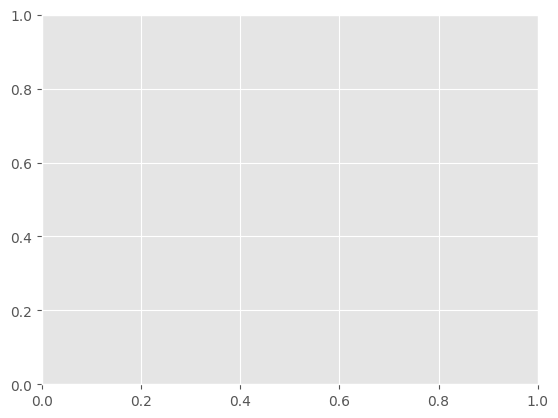

In [10]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

## Evaluating

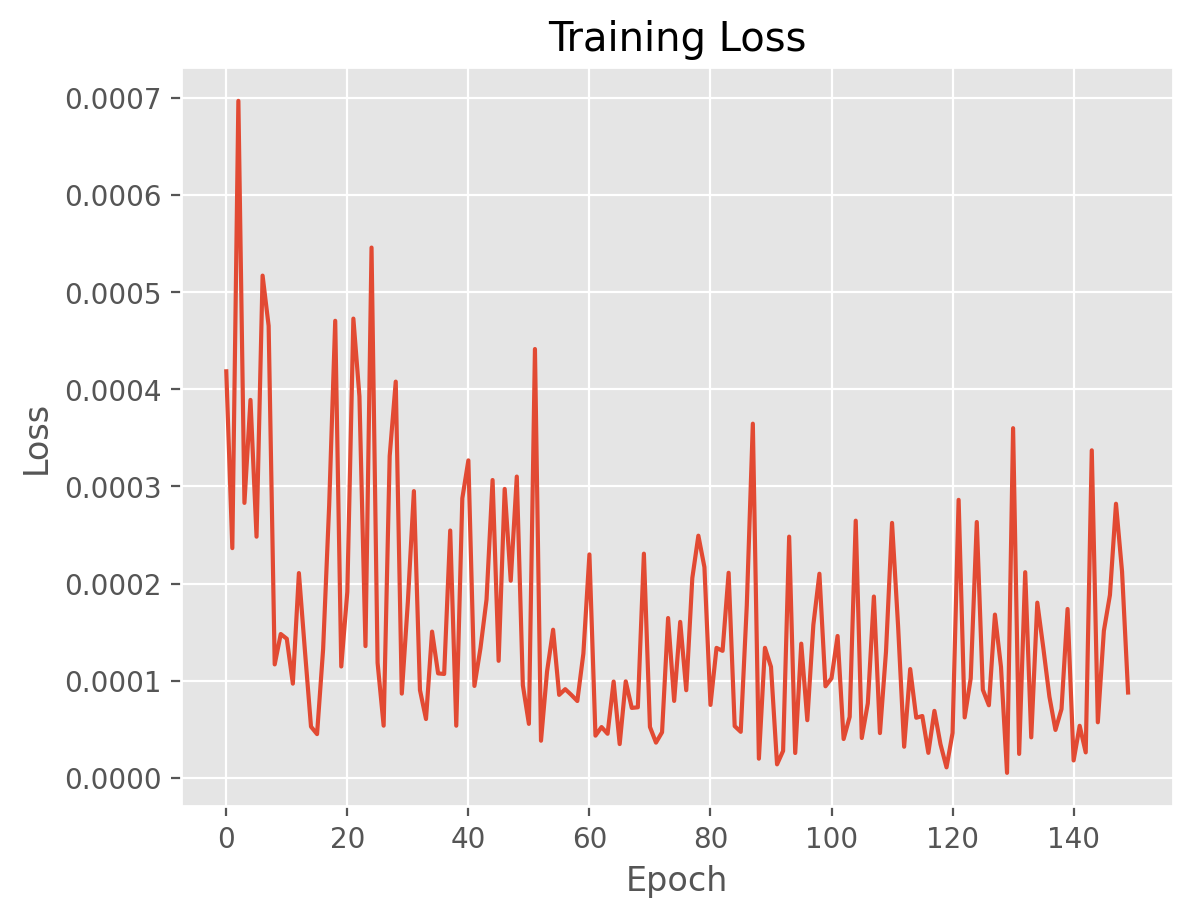

In [11]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

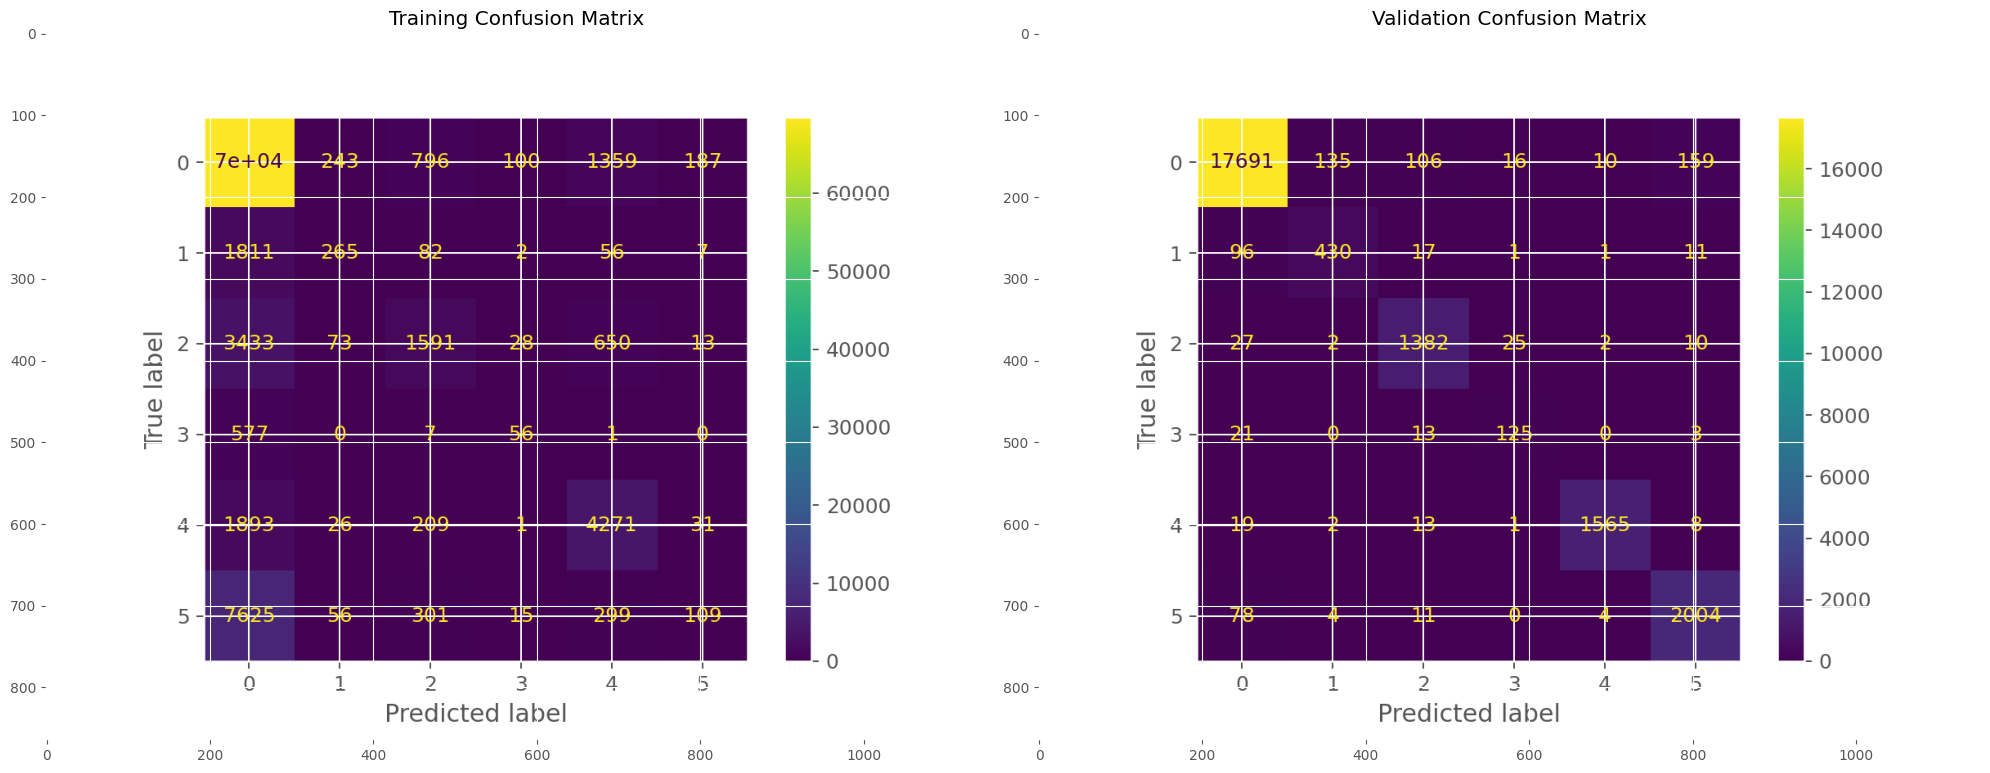

In [12]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


## Save model and load model

In [14]:
import torch
torch.save(model, "..\\model_save\\model.pth")
model_test = torch.load("..\\model_save\\model.pth")
print(model_test)

ECGformer(
  (encoder): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): Linear(in_features=192, out_features=192, bias=True)
            (values_projection): Linear(in_features=192, out_features=192, bias=True)
            (keys_projection): Linear(in_features=192, out_features=192, bias=True)
            (final_projection): Linear(in_features=192, out_features=192, bias=True)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (0): Linear(in_features=192, out_features=768, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=768, out_features=192, bias=True)
          )
          (2):

In [15]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
torch.save(quantized_model, "..\\model_save\\model_quantized.pth")
model_test = torch.load("..\\model_save\\model_quantized.pth")

print(model_test)


ECGformer(
  (encoder): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (values_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (keys_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (final_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)


C:\Users\Chen_Lab01\anaconda3\envs\pytorch-ecg\lib\site-packages\torch\_utils.py:383: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [29]:
import einops
loader = get_data_loaders(DatasetConfig())
accuracy = 0
for signal, label in loader[Mode.eval]:
    p = model_test(einops.rearrange(signal, "b c e -> b e c"))
    print(p)
    print(label)
    # print(signal.shape, label.shape)
    print(p.argmax(1) == label)
    accuracy += torch.sum(p.argmax(1) == label)
    print(f"accuracy: {accuracy / config.dataset.batch_size}")
    break



tensor([[ 0.3404,  0.0706,  0.1221, -0.4536, -0.9222, -0.3865],
        [ 0.3200,  0.0658,  0.0803, -0.4135, -0.8871, -0.3868],
        [ 0.3360,  0.0797,  0.1190, -0.4383, -0.9028, -0.3893],
        [ 0.3467,  0.0846,  0.1211, -0.4581, -0.9185, -0.3761],
        [ 0.3109,  0.0794,  0.0513, -0.4120, -0.8589, -0.4093],
        [ 0.3147,  0.0674,  0.0409, -0.4203, -0.8298, -0.3941],
        [ 0.3504,  0.0898,  0.1693, -0.4704, -0.9681, -0.3650],
        [ 0.3501,  0.0806,  0.1302, -0.4428, -0.9496, -0.3695],
        [ 0.3468,  0.0859,  0.1514, -0.4717, -0.9444, -0.3806],
        [ 0.3064,  0.0745,  0.0355, -0.4224, -0.8174, -0.3941],
        [ 0.3095,  0.0605,  0.0702, -0.4130, -0.8762, -0.3918],
        [ 0.3244,  0.0776,  0.0791, -0.4335, -0.8848, -0.3937],
        [ 0.3540,  0.0944,  0.1495, -0.4664, -0.9852, -0.3593],
        [ 0.3174,  0.0754,  0.0726, -0.4196, -0.8816, -0.3954],
        [ 0.3116,  0.0751,  0.0651, -0.4148, -0.8896, -0.3974],
        [ 0.3323,  0.0639,  0.0945, -0.4

## Parameter 提取

In [17]:
for name in model_test.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco